In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import cv2
import h5py
import os
import random

import warnings
warnings.filterwarnings("ignore")

# Create Pairs

In [2]:
ground_truth = pd.read_csv('.\COMP90086_2023_TLLdataset\\train.csv')

# Create a dictionary for lookup
gt_dict = ground_truth.set_index('left').to_dict()['right']

def create_training_dataset(left_folder, right_folder, ground_truth, num_foils=5, seed=123):
    random.seed(seed)
    left_images = [img_name.replace('.jpg', '') for img_name in os.listdir(left_folder)]
    right_images = [img_name.replace('.jpg', '') for img_name in os.listdir(right_folder)]

    paired_data = []
    labels = []

    for left_img_name in left_images:
        true_match = ground_truth[left_img_name]

        foils = [img for img in right_images if img != true_match]
        random.shuffle(foils)
        foils = foils[:num_foils]

        paired_data.append((left_img_name, true_match))
        labels.append(1)  # 1 indicates a true match

        for foil in foils:
            paired_data.append((left_img_name, foil))
            labels.append(0)  # 0 indicates a non-match

    return paired_data, labels

# Creating paired data and labels
paired_data, labels = create_training_dataset(".\COMP90086_2023_TLLdataset\\train\\left",
                                              ".\COMP90086_2023_TLLdataset\\train\\right",
                                              gt_dict)

labels = np.array(labels)

# L1 Distance

## vgg

In [3]:
left_train = np.load('vgg_train_left.npy')
right_train = np.load('vgg_train_right.npy')
left_test = np.load('vgg_test_left.npy')
right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [4]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [5]:
input_shape = (512,)
# input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model

# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_network(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    shared_network = create_shared_network(input_shape)
    left_features = shared_network(left_input)
    right_features = shared_network(right_input)

    distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([left_features, right_features])
    normal_layer = tf.keras.layers.BatchNormalization()(distance)
    similarity_score = Dense(1, activation='sigmoid')(distance)
    
#     distance = Lambda(euclidean_distance)([left_features, right_features])
#     normal_layer = tf.keras.layers.BatchNormalization()(distance)
#     similarity_score = layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_net = Model(inputs=[left_input, right_input], outputs=1-similarity_score)
    return siamese_net
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\vgg_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\vgg_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [6]:
# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def loss():
    margin=1
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [7]:
batch_size = 16
no_layer = 1
lr = 0.001
model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

epochs = 100
history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.1409 - accuracy: 0.8291 - recall: 0.0094 - val_loss: 0.1309 - val_accuracy: 0.8342 - val_recall: 0.0250
Epoch 2/100
600/600 - 1s - loss: 0.1151 - accuracy: 0.8499 - recall: 0.1406 - val_loss: 0.1320 - val_accuracy: 0.8300 - val_recall: 0.0475
Epoch 3/100
600/600 - 1s - loss: 0.0950 - accuracy: 0.8819 - recall: 0.3556 - val_loss: 0.1398 - val_accuracy: 0.8158 - val_recall: 0.1475
Epoch 4/100
600/600 - 1s - loss: 0.0754 - accuracy: 0.9118 - recall: 0.5281 - val_loss: 0.1436 - val_accuracy: 0.8100 - val_recall: 0.1450
Epoch 5/100
600/600 - 1s - loss: 0.0573 - accuracy: 0.9381 - recall: 0.6712 - val_loss: 0.1525 - val_accuracy: 0.8033 - val_recall: 0.1850
Epoch 6/100
600/600 - 1s - loss: 0.0433 - accuracy: 0.9564 - recall: 0.7700 - val_loss: 0.1576 - val_accuracy: 0.8000 - val_recall: 0.1750
Epoch 7/100
600/600 - 1s - loss: 0.0329 - accuracy: 0.9703 - recall: 0.8369 - val_loss: 0.1783 - val_accuracy: 0.7613 - val_recall: 0.2350
Epoch 8/100
600/600 - 1s - 

Epoch 60/100
600/600 - 1s - loss: 0.0136 - accuracy: 0.9861 - recall: 0.9206 - val_loss: 0.2028 - val_accuracy: 0.7817 - val_recall: 0.1625
Epoch 61/100
600/600 - 1s - loss: 0.0131 - accuracy: 0.9868 - recall: 0.9237 - val_loss: 0.2086 - val_accuracy: 0.7746 - val_recall: 0.1875
Epoch 62/100
600/600 - 1s - loss: 0.0124 - accuracy: 0.9877 - recall: 0.9262 - val_loss: 0.2033 - val_accuracy: 0.7829 - val_recall: 0.1850
Epoch 63/100
600/600 - 1s - loss: 0.0131 - accuracy: 0.9869 - recall: 0.9237 - val_loss: 0.2047 - val_accuracy: 0.7812 - val_recall: 0.1800
Epoch 64/100
600/600 - 1s - loss: 0.0144 - accuracy: 0.9847 - recall: 0.9175 - val_loss: 0.2043 - val_accuracy: 0.7783 - val_recall: 0.2075
Epoch 65/100
600/600 - 1s - loss: 0.0154 - accuracy: 0.9835 - recall: 0.9156 - val_loss: 0.2024 - val_accuracy: 0.7817 - val_recall: 0.1975
Epoch 66/100
600/600 - 1s - loss: 0.0131 - accuracy: 0.9868 - recall: 0.9237 - val_loss: 0.2031 - val_accuracy: 0.7808 - val_recall: 0.2100
Epoch 67/100
600/600

#### Predict

In [8]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

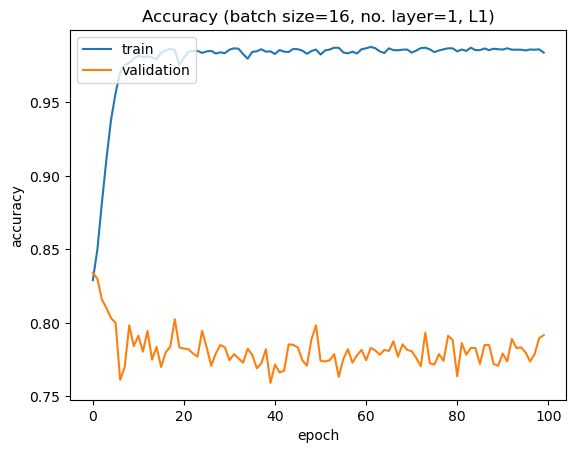

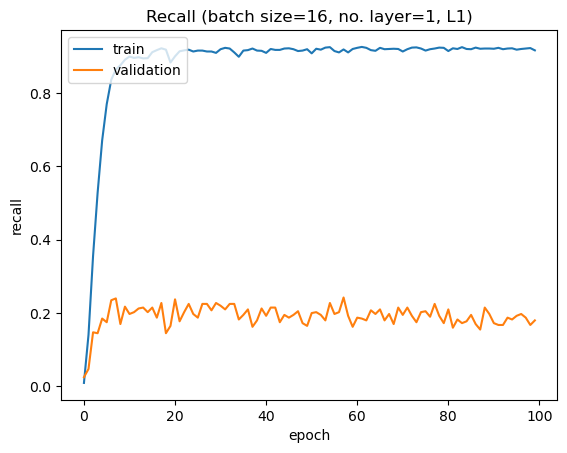

In [9]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [10]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.015
Training Accuracy: 0.984
Training Recall: 0.917


Validation Loss: 0.197
Validation Accuracy: 0.792
Validation Recall: 0.18


### batch size = 32, number of layer = 1

In [11]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 0s - loss: 0.1434 - accuracy: 0.8288 - recall_1: 0.0125 - val_loss: 0.1372 - val_accuracy: 0.8329 - val_recall_1: 0.0025
Epoch 2/100
300/300 - 0s - loss: 0.1169 - accuracy: 0.8485 - recall_1: 0.1213 - val_loss: 0.1364 - val_accuracy: 0.8188 - val_recall_1: 0.0625
Epoch 3/100
300/300 - 0s - loss: 0.0962 - accuracy: 0.8809 - recall_1: 0.3269 - val_loss: 0.1382 - val_accuracy: 0.8208 - val_recall_1: 0.0950
Epoch 4/100
300/300 - 0s - loss: 0.0757 - accuracy: 0.9102 - recall_1: 0.5088 - val_loss: 0.1456 - val_accuracy: 0.8067 - val_recall_1: 0.1125
Epoch 5/100
300/300 - 0s - loss: 0.0569 - accuracy: 0.9397 - recall_1: 0.6706 - val_loss: 0.1573 - val_accuracy: 0.7875 - val_recall_1: 0.1475
Epoch 6/100
300/300 - 0s - loss: 0.0425 - accuracy: 0.9594 - recall_1: 0.7806 - val_loss: 0.1563 - val_accuracy: 0.8017 - val_recall_1: 0.1400
Epoch 7/100
300/300 - 0s - loss: 0.0308 - accuracy: 0.9733 - recall_1: 0.8525 - val_loss: 0.1650 - val_accuracy: 0.7867 - val_recall_1: 0.1700

Epoch 58/100
300/300 - 0s - loss: 0.0087 - accuracy: 0.9910 - recall_1: 0.9506 - val_loss: 0.2024 - val_accuracy: 0.7729 - val_recall_1: 0.1800
Epoch 59/100
300/300 - 0s - loss: 0.0081 - accuracy: 0.9919 - recall_1: 0.9538 - val_loss: 0.2016 - val_accuracy: 0.7767 - val_recall_1: 0.1775
Epoch 60/100
300/300 - 0s - loss: 0.0076 - accuracy: 0.9924 - recall_1: 0.9550 - val_loss: 0.2017 - val_accuracy: 0.7733 - val_recall_1: 0.1825
Epoch 61/100
300/300 - 0s - loss: 0.0075 - accuracy: 0.9925 - recall_1: 0.9556 - val_loss: 0.2028 - val_accuracy: 0.7754 - val_recall_1: 0.1950
Epoch 62/100
300/300 - 0s - loss: 0.0073 - accuracy: 0.9927 - recall_1: 0.9563 - val_loss: 0.2021 - val_accuracy: 0.7758 - val_recall_1: 0.1925
Epoch 63/100
300/300 - 0s - loss: 0.0074 - accuracy: 0.9926 - recall_1: 0.9556 - val_loss: 0.1975 - val_accuracy: 0.7812 - val_recall_1: 0.1800
Epoch 64/100
300/300 - 0s - loss: 0.0074 - accuracy: 0.9926 - recall_1: 0.9556 - val_loss: 0.2012 - val_accuracy: 0.7779 - val_recall_1:

#### Predict

In [12]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

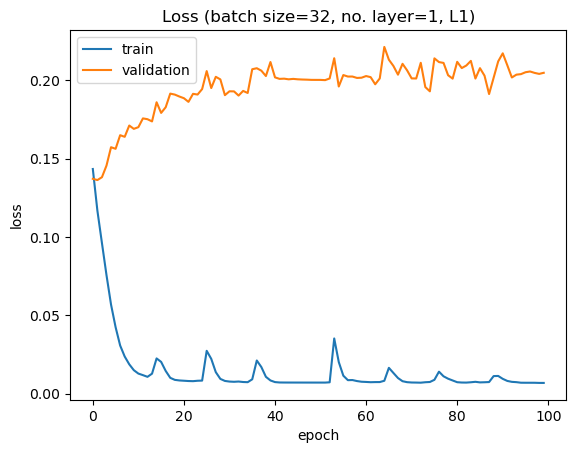

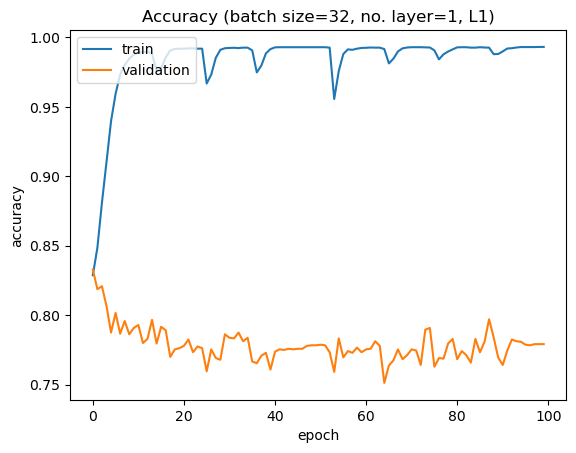

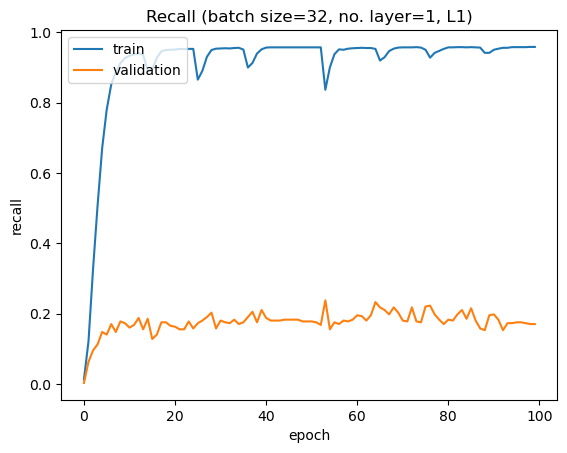

In [13]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [14]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.007
Training Accuracy: 0.993
Training Recall: 0.959


Validation Loss: 0.205
Validation Accuracy: 0.779
Validation Recall: 0.17


### batch size = 64, number of layer = 1

In [15]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 0s - loss: 0.1398 - accuracy: 0.8308 - recall_2: 0.0075 - val_loss: 0.1322 - val_accuracy: 0.8329 - val_recall_2: 0.0075
Epoch 2/100
150/150 - 0s - loss: 0.1149 - accuracy: 0.8499 - recall_2: 0.1244 - val_loss: 0.1328 - val_accuracy: 0.8229 - val_recall_2: 0.0775
Epoch 3/100
150/150 - 0s - loss: 0.0937 - accuracy: 0.8848 - recall_2: 0.3450 - val_loss: 0.1323 - val_accuracy: 0.8296 - val_recall_2: 0.0425
Epoch 4/100
150/150 - 0s - loss: 0.0721 - accuracy: 0.9205 - recall_2: 0.5450 - val_loss: 0.1419 - val_accuracy: 0.8112 - val_recall_2: 0.1775
Epoch 5/100
150/150 - 0s - loss: 0.0552 - accuracy: 0.9442 - recall_2: 0.6875 - val_loss: 0.1488 - val_accuracy: 0.7979 - val_recall_2: 0.1825
Epoch 6/100
150/150 - 0s - loss: 0.0398 - accuracy: 0.9661 - recall_2: 0.8075 - val_loss: 0.1527 - val_accuracy: 0.7971 - val_recall_2: 0.2100
Epoch 7/100
150/150 - 0s - loss: 0.0285 - accuracy: 0.9775 - recall_2: 0.8675 - val_loss: 0.1590 - val_accuracy: 0.7892 - val_recall_2: 0.2050

Epoch 58/100
150/150 - 0s - loss: 0.0041 - accuracy: 0.9959 - recall_2: 0.9756 - val_loss: 0.1911 - val_accuracy: 0.7854 - val_recall_2: 0.1775
Epoch 59/100
150/150 - 0s - loss: 0.0041 - accuracy: 0.9959 - recall_2: 0.9756 - val_loss: 0.1933 - val_accuracy: 0.7792 - val_recall_2: 0.1850
Epoch 60/100
150/150 - 0s - loss: 0.0041 - accuracy: 0.9959 - recall_2: 0.9756 - val_loss: 0.1934 - val_accuracy: 0.7788 - val_recall_2: 0.1850
Epoch 61/100
150/150 - 0s - loss: 0.0041 - accuracy: 0.9959 - recall_2: 0.9756 - val_loss: 0.1928 - val_accuracy: 0.7800 - val_recall_2: 0.1850
Epoch 62/100
150/150 - 0s - loss: 0.0041 - accuracy: 0.9959 - recall_2: 0.9756 - val_loss: 0.1930 - val_accuracy: 0.7788 - val_recall_2: 0.1850
Epoch 63/100
150/150 - 0s - loss: 0.0041 - accuracy: 0.9959 - recall_2: 0.9756 - val_loss: 0.1929 - val_accuracy: 0.7796 - val_recall_2: 0.1850
Epoch 64/100
150/150 - 0s - loss: 0.0041 - accuracy: 0.9959 - recall_2: 0.9756 - val_loss: 0.1929 - val_accuracy: 0.7800 - val_recall_2:

#### Predict

In [16]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

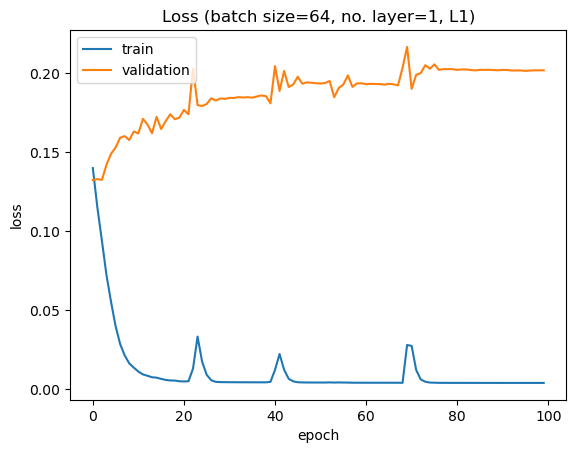

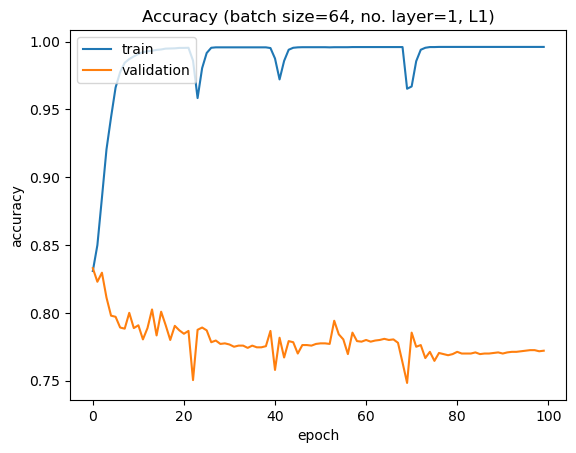

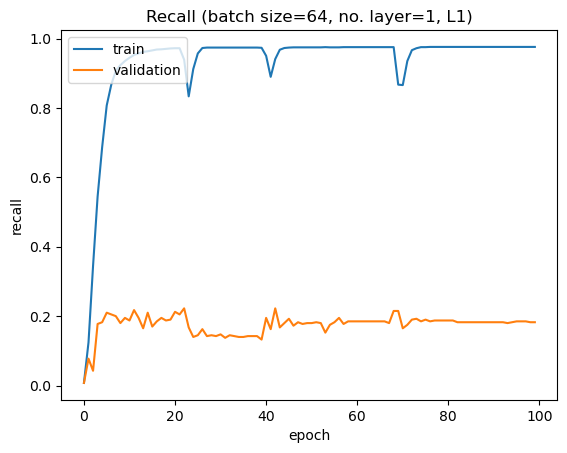

In [17]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [18]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.004
Training Accuracy: 0.996
Training Recall: 0.976


Validation Loss: 0.202
Validation Accuracy: 0.772
Validation Recall: 0.183


### batch size = 16, number of layer = 2

In [19]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\vgg_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\vgg_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [20]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.1537 - accuracy: 0.8296 - recall_3: 0.0075 - val_loss: 0.1871 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1452 - accuracy: 0.8328 - recall_3: 0.0000e+00 - val_loss: 0.1598 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1425 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1530 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1420 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1399 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1445 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1344 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1380 - accuracy: 0.8332 - recall_3: 0.0000e+00 - val_loss: 0.13

Epoch 56/100
600/600 - 1s - loss: 0.1308 - accuracy: 0.8327 - recall_3: 0.0181 - val_loss: 0.1317 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 57/100
600/600 - 1s - loss: 0.1292 - accuracy: 0.8357 - recall_3: 0.0250 - val_loss: 0.1315 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 58/100
600/600 - 1s - loss: 0.1297 - accuracy: 0.8341 - recall_3: 0.0262 - val_loss: 0.1302 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 59/100
600/600 - 1s - loss: 0.1298 - accuracy: 0.8336 - recall_3: 0.0206 - val_loss: 0.1323 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 60/100
600/600 - 1s - loss: 0.1292 - accuracy: 0.8350 - recall_3: 0.0362 - val_loss: 0.1319 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 61/100
600/600 - 1s - loss: 0.1287 - accuracy: 0.8348 - recall_3: 0.0281 - val_loss: 0.1324 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 62/100
600/600 - 1s - loss: 0.1287 - accuracy: 0.8350 - recall_3: 0.0325 - val_loss: 0.1306 - val_accuracy

#### Predict

In [21]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

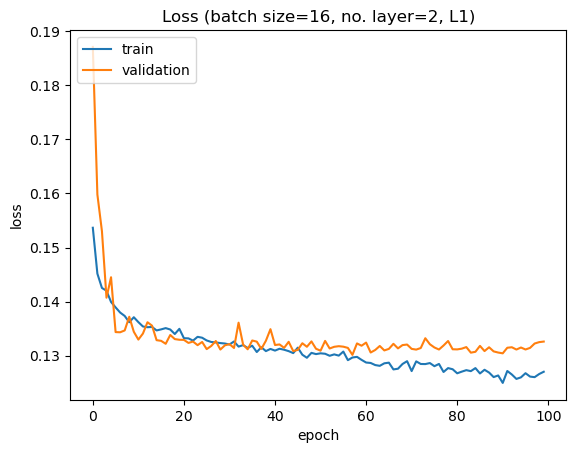

In [22]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [23]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.127
Training Accuracy: 0.835
Training Recall: 0.039


Validation Loss: 0.133
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [24]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1577 - accuracy: 0.8295 - recall_4: 0.0050 - val_loss: 0.1673 - val_accuracy: 0.8325 - val_recall_4: 0.0000e+00
Epoch 2/100
300/300 - 0s - loss: 0.1442 - accuracy: 0.8331 - recall_4: 0.0019 - val_loss: 0.1625 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 3/100
300/300 - 0s - loss: 0.1439 - accuracy: 0.8331 - recall_4: 6.2500e-04 - val_loss: 0.1504 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 4/100
300/300 - 0s - loss: 0.1412 - accuracy: 0.8334 - recall_4: 6.2500e-04 - val_loss: 0.1474 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 5/100
300/300 - 0s - loss: 0.1407 - accuracy: 0.8332 - recall_4: 0.0000e+00 - val_loss: 0.1366 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 6/100
300/300 - 0s - loss: 0.1406 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1403 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 7/100
300/300 - 0s - loss: 0.1386 - accuracy: 0.8333 - recall_4: 6.2500e-04 - val_loss: 0.1381 -

Epoch 57/100
300/300 - 0s - loss: 0.1260 - accuracy: 0.8345 - recall_4: 0.0388 - val_loss: 0.1322 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 58/100
300/300 - 0s - loss: 0.1278 - accuracy: 0.8351 - recall_4: 0.0288 - val_loss: 0.1306 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 59/100
300/300 - 0s - loss: 0.1275 - accuracy: 0.8343 - recall_4: 0.0325 - val_loss: 0.1319 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 60/100
300/300 - 0s - loss: 0.1276 - accuracy: 0.8350 - recall_4: 0.0281 - val_loss: 0.1313 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 61/100
300/300 - 0s - loss: 0.1269 - accuracy: 0.8343 - recall_4: 0.0344 - val_loss: 0.1321 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 62/100
300/300 - 0s - loss: 0.1263 - accuracy: 0.8354 - recall_4: 0.0394 - val_loss: 0.1325 - val_accuracy: 0.8329 - val_recall_4: 0.0000e+00
Epoch 63/100
300/300 - 0s - loss: 0.1261 - accuracy: 0.8338 - recall_4: 0.0350 - val_loss: 0.1316 - val_accuracy

#### Predict

In [25]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

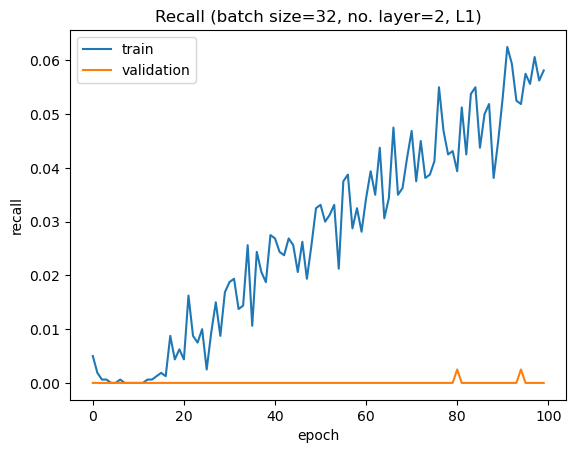

In [26]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [27]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.123
Training Accuracy: 0.837
Training Recall: 0.058


Validation Loss: 0.132
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [28]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1569 - accuracy: 0.8248 - recall_5: 0.0119 - val_loss: 0.1430 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 2/100
150/150 - 0s - loss: 0.1455 - accuracy: 0.8321 - recall_5: 0.0019 - val_loss: 0.1432 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 3/100
150/150 - 0s - loss: 0.1416 - accuracy: 0.8332 - recall_5: 0.0000e+00 - val_loss: 0.1430 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 4/100
150/150 - 0s - loss: 0.1411 - accuracy: 0.8331 - recall_5: 0.0000e+00 - val_loss: 0.1443 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 5/100
150/150 - 0s - loss: 0.1406 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1467 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 6/100
150/150 - 0s - loss: 0.1396 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 7/100
150/150 - 0s - loss: 0.1386 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1436 -

Epoch 56/100
150/150 - 0s - loss: 0.1272 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1325 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 57/100
150/150 - 0s - loss: 0.1278 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1336 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 58/100
150/150 - 0s - loss: 0.1282 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1336 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 59/100
150/150 - 0s - loss: 0.1270 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1352 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 60/100
150/150 - 0s - loss: 0.1266 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1326 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 61/100
150/150 - 0s - loss: 0.1264 - accuracy: 0.8332 - recall_5: 0.0000e+00 - val_loss: 0.1350 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 62/100
150/150 - 0s - loss: 0.1268 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val

#### Predict

In [29]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

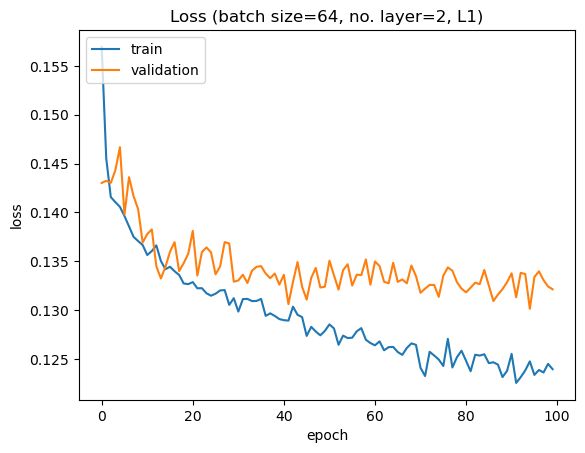

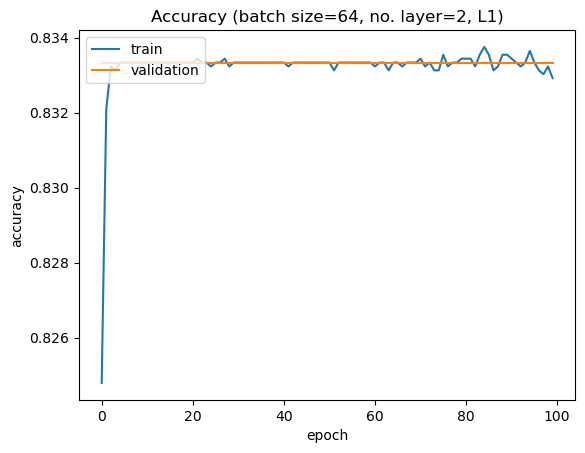

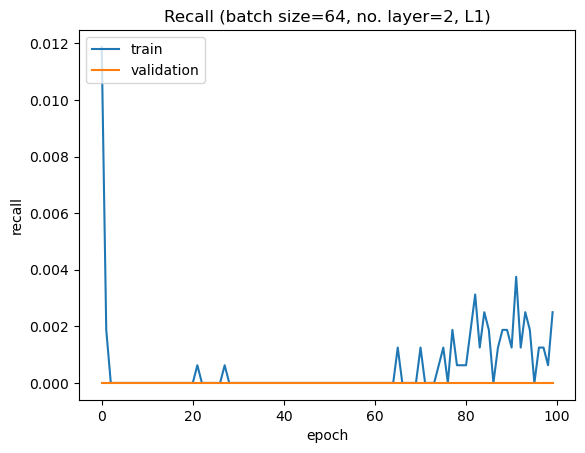

In [30]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [31]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.124
Training Accuracy: 0.833
Training Recall: 0.002


Validation Loss: 0.132
Validation Accuracy: 0.833
Validation Recall: 0.0


## resnet

In [32]:
# left_train = np.load('vgg_train_left.npy')
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

left_train = np.load('resnet_train_left.npy')
right_train = np.load('resnet_train_right.npy')
left_test = np.load('resnet_test_left.npy')
right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [33]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [34]:
# input_shape = (512,)
input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\resnet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\resnet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [35]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1656 - accuracy: 0.8326 - recall_6: 0.0037 - val_loss: 0.1663 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1647 - accuracy: 0.8315 - recall_6: 0.0094 - val_loss: 0.1694 - val_accuracy: 0.8233 - val_recall_6: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1637 - accuracy: 0.8318 - recall_6: 0.0306 - val_loss: 0.1653 - val_accuracy: 0.8296 - val_recall_6: 0.0175
Epoch 4/100
600/600 - 1s - loss: 0.1569 - accuracy: 0.8377 - recall_6: 0.0600 - val_loss: 0.1630 - val_accuracy: 0.8317 - val_recall_6: 0.0100
Epoch 5/100
600/600 - 1s - loss: 0.1520 - accuracy: 0.8391 - recall_6: 0.1063 - val_loss: 0.1633 - val_accuracy: 0.8329 - val_recall_6: 0.0025
Epoch 6/100
600/600 - 1s - loss: 0.1421 - accuracy: 0.8479 - recall_6: 0.1544 - val_loss: 0.1593 - val_accuracy: 0.8283 - val_recall_6: 0.0525
Epoch 7/100
600/600 - 1s - loss: 0.1302 - accuracy: 0.8602 - recall_6: 0.2200 - val_loss: 0.1582 - val_accuracy: 0.8275 - val_recall_6

Epoch 58/100
600/600 - 1s - loss: 0.0608 - accuracy: 0.9383 - recall_6: 0.6413 - val_loss: 0.1989 - val_accuracy: 0.7933 - val_recall_6: 0.1550
Epoch 59/100
600/600 - 1s - loss: 0.0597 - accuracy: 0.9398 - recall_6: 0.6488 - val_loss: 0.2123 - val_accuracy: 0.7783 - val_recall_6: 0.1500
Epoch 60/100
600/600 - 1s - loss: 0.0606 - accuracy: 0.9388 - recall_6: 0.6431 - val_loss: 0.1889 - val_accuracy: 0.8058 - val_recall_6: 0.1200
Epoch 61/100
600/600 - 1s - loss: 0.0589 - accuracy: 0.9407 - recall_6: 0.6513 - val_loss: 0.1842 - val_accuracy: 0.8100 - val_recall_6: 0.1150
Epoch 62/100
600/600 - 1s - loss: 0.0600 - accuracy: 0.9395 - recall_6: 0.6463 - val_loss: 0.1988 - val_accuracy: 0.7921 - val_recall_6: 0.1175
Epoch 63/100
600/600 - 1s - loss: 0.0610 - accuracy: 0.9377 - recall_6: 0.6413 - val_loss: 0.1945 - val_accuracy: 0.7958 - val_recall_6: 0.1025
Epoch 64/100
600/600 - 1s - loss: 0.0606 - accuracy: 0.9392 - recall_6: 0.6425 - val_loss: 0.1849 - val_accuracy: 0.8100 - val_recall_6:

#### Predict

In [36]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

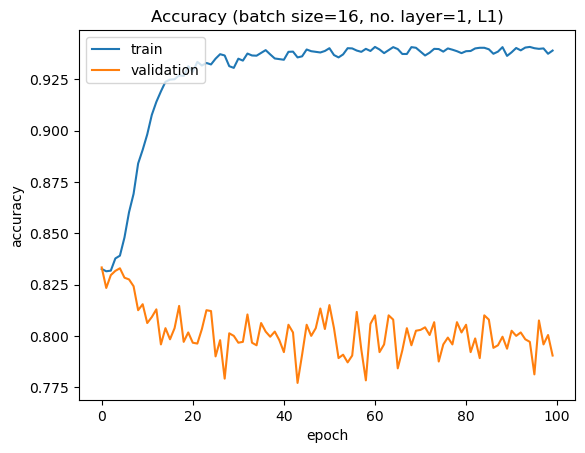

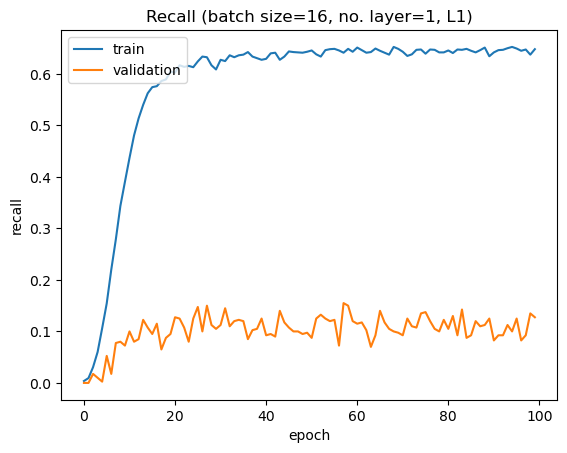

In [37]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [38]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.06
Training Accuracy: 0.939
Training Recall: 0.648


Validation Loss: 0.203
Validation Accuracy: 0.79
Validation Recall: 0.127


### batch size = 32, number of layer = 1

In [39]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1621 - accuracy: 0.8290 - recall_7: 0.0119 - val_loss: 0.1634 - val_accuracy: 0.8333 - val_recall_7: 0.0000e+00
Epoch 2/100
300/300 - 1s - loss: 0.1514 - accuracy: 0.8298 - recall_7: 0.0463 - val_loss: 0.1505 - val_accuracy: 0.8313 - val_recall_7: 0.0075
Epoch 3/100
300/300 - 1s - loss: 0.1309 - accuracy: 0.8395 - recall_7: 0.1106 - val_loss: 0.1416 - val_accuracy: 0.8279 - val_recall_7: 0.0400
Epoch 4/100
300/300 - 1s - loss: 0.1146 - accuracy: 0.8591 - recall_7: 0.2131 - val_loss: 0.1461 - val_accuracy: 0.8300 - val_recall_7: 0.0175
Epoch 5/100
300/300 - 1s - loss: 0.1041 - accuracy: 0.8727 - recall_7: 0.3119 - val_loss: 0.1538 - val_accuracy: 0.8000 - val_recall_7: 0.0525
Epoch 6/100
300/300 - 1s - loss: 0.0898 - accuracy: 0.8950 - recall_7: 0.4431 - val_loss: 0.1598 - val_accuracy: 0.8083 - val_recall_7: 0.0625
Epoch 7/100
300/300 - 1s - loss: 0.0784 - accuracy: 0.9103 - recall_7: 0.5288 - val_loss: 0.1669 - val_accuracy: 0.7946 - val_recall_7: 0.

Epoch 58/100
300/300 - 1s - loss: 0.0280 - accuracy: 0.9716 - recall_7: 0.8388 - val_loss: 0.2050 - val_accuracy: 0.7846 - val_recall_7: 0.1050
Epoch 59/100
300/300 - 1s - loss: 0.0281 - accuracy: 0.9712 - recall_7: 0.8363 - val_loss: 0.1963 - val_accuracy: 0.7950 - val_recall_7: 0.0875
Epoch 60/100
300/300 - 1s - loss: 0.0278 - accuracy: 0.9719 - recall_7: 0.8419 - val_loss: 0.2151 - val_accuracy: 0.7738 - val_recall_7: 0.1000
Epoch 61/100
300/300 - 1s - loss: 0.0302 - accuracy: 0.9681 - recall_7: 0.8269 - val_loss: 0.2088 - val_accuracy: 0.7783 - val_recall_7: 0.1000
Epoch 62/100
300/300 - 1s - loss: 0.0303 - accuracy: 0.9684 - recall_7: 0.8275 - val_loss: 0.2263 - val_accuracy: 0.7621 - val_recall_7: 0.1150
Epoch 63/100
300/300 - 1s - loss: 0.0284 - accuracy: 0.9709 - recall_7: 0.8375 - val_loss: 0.2063 - val_accuracy: 0.7846 - val_recall_7: 0.0825
Epoch 64/100
300/300 - 1s - loss: 0.0271 - accuracy: 0.9727 - recall_7: 0.8438 - val_loss: 0.2242 - val_accuracy: 0.7638 - val_recall_7:

#### Predict

In [40]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

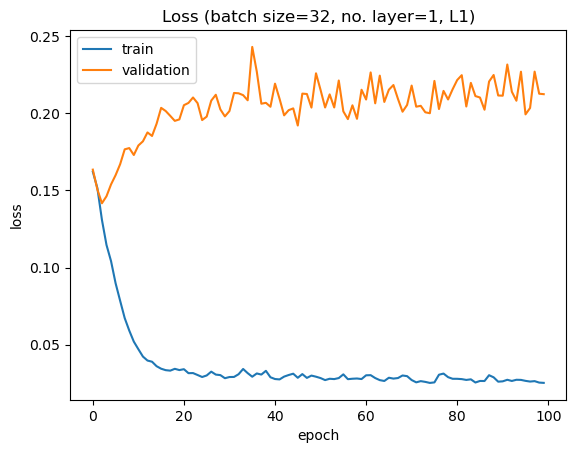

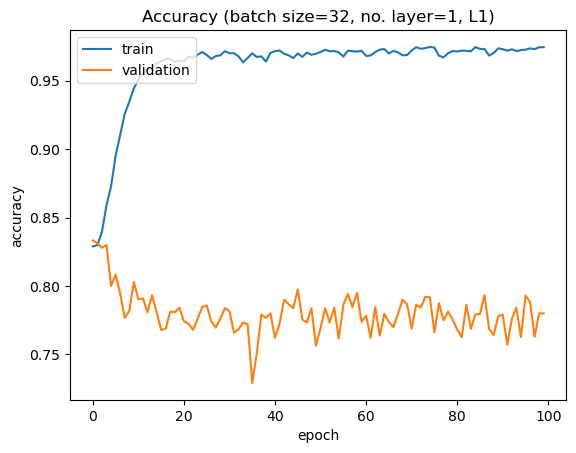

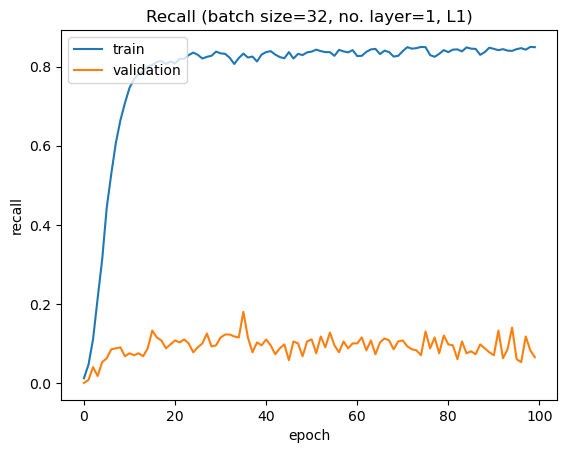

In [41]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [42]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.025
Training Accuracy: 0.974
Training Recall: 0.849


Validation Loss: 0.212
Validation Accuracy: 0.78
Validation Recall: 0.065


### batch size = 64, number of layer = 1

In [43]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1678 - accuracy: 0.8311 - recall_8: 0.0012 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_8: 0.0000e+00
Epoch 2/100
150/150 - 0s - loss: 0.1650 - accuracy: 0.8323 - recall_8: 0.0037 - val_loss: 0.1657 - val_accuracy: 0.8308 - val_recall_8: 0.0050
Epoch 3/100
150/150 - 0s - loss: 0.1608 - accuracy: 0.8332 - recall_8: 0.0344 - val_loss: 0.1649 - val_accuracy: 0.8317 - val_recall_8: 0.0025
Epoch 4/100
150/150 - 0s - loss: 0.1511 - accuracy: 0.8414 - recall_8: 0.0925 - val_loss: 0.1656 - val_accuracy: 0.8292 - val_recall_8: 0.0150
Epoch 5/100
150/150 - 0s - loss: 0.1442 - accuracy: 0.8465 - recall_8: 0.1344 - val_loss: 0.1662 - val_accuracy: 0.8204 - val_recall_8: 0.0175
Epoch 6/100
150/150 - 0s - loss: 0.1326 - accuracy: 0.8576 - recall_8: 0.2069 - val_loss: 0.1651 - val_accuracy: 0.8263 - val_recall_8: 0.0150
Epoch 7/100
150/150 - 1s - loss: 0.1203 - accuracy: 0.8723 - recall_8: 0.2831 - val_loss: 0.1694 - val_accuracy: 0.8083 - val_recall_8: 0.

Epoch 58/100
150/150 - 1s - loss: 0.0524 - accuracy: 0.9474 - recall_8: 0.6869 - val_loss: 0.1993 - val_accuracy: 0.7871 - val_recall_8: 0.0725
Epoch 59/100
150/150 - 1s - loss: 0.0517 - accuracy: 0.9484 - recall_8: 0.6906 - val_loss: 0.2052 - val_accuracy: 0.7825 - val_recall_8: 0.1075
Epoch 60/100
150/150 - 1s - loss: 0.0522 - accuracy: 0.9475 - recall_8: 0.6888 - val_loss: 0.2037 - val_accuracy: 0.7833 - val_recall_8: 0.0850
Epoch 61/100
150/150 - 1s - loss: 0.0527 - accuracy: 0.9470 - recall_8: 0.6862 - val_loss: 0.2010 - val_accuracy: 0.7875 - val_recall_8: 0.0825
Epoch 62/100
150/150 - 1s - loss: 0.0531 - accuracy: 0.9464 - recall_8: 0.6844 - val_loss: 0.2064 - val_accuracy: 0.7792 - val_recall_8: 0.0875
Epoch 63/100
150/150 - 1s - loss: 0.0540 - accuracy: 0.9450 - recall_8: 0.6800 - val_loss: 0.1990 - val_accuracy: 0.7900 - val_recall_8: 0.0575
Epoch 64/100
150/150 - 1s - loss: 0.0530 - accuracy: 0.9465 - recall_8: 0.6862 - val_loss: 0.2149 - val_accuracy: 0.7750 - val_recall_8:

#### Predict

In [44]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

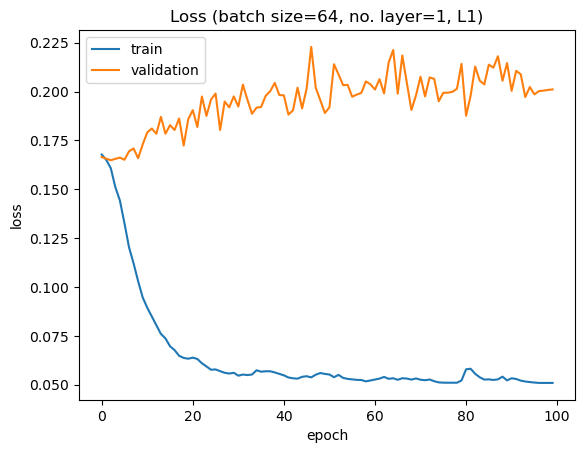

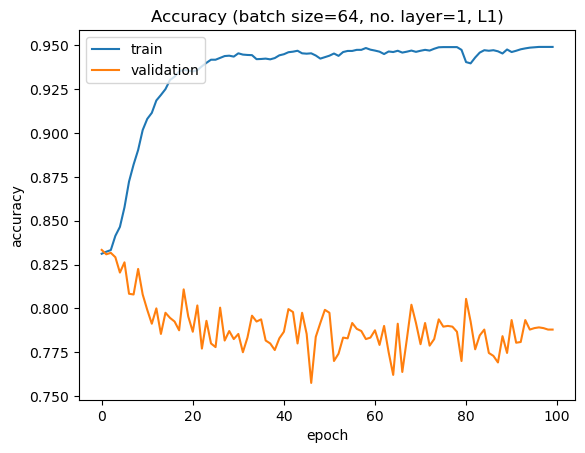

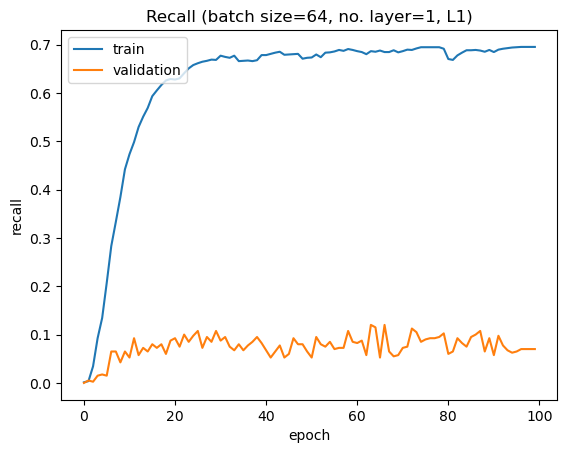

In [45]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [46]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.051
Training Accuracy: 0.949
Training Recall: 0.695


Validation Loss: 0.201
Validation Accuracy: 0.788
Validation Recall: 0.07


### batch size = 16, number of layer = 2

In [47]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\resnet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\resnet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [48]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1706 - accuracy: 0.8279 - recall_9: 0.0088 - val_loss: 0.1654 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 2/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1660 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 3/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8332 - recall_9: 0.0000e+00 - val_loss: 0.1661 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1660 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 5/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1660 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 6/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1661 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 7/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.16

Epoch 54/100
600/600 - 1s - loss: 0.1668 - accuracy: 0.8332 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 55/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 56/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 57/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 58/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 59/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 60/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val

#### Predict

In [49]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

In [50]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [51]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [52]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1697 - accuracy: 0.8291 - recall_10: 0.0069 - val_loss: 0.1660 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 2/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1660 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 3/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1660 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 4/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1661 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 5/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1661 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 6/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1661 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 7/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - v

Epoch 55/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 56/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 57/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 58/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 59/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 60/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 61/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0

#### Predict

In [53]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

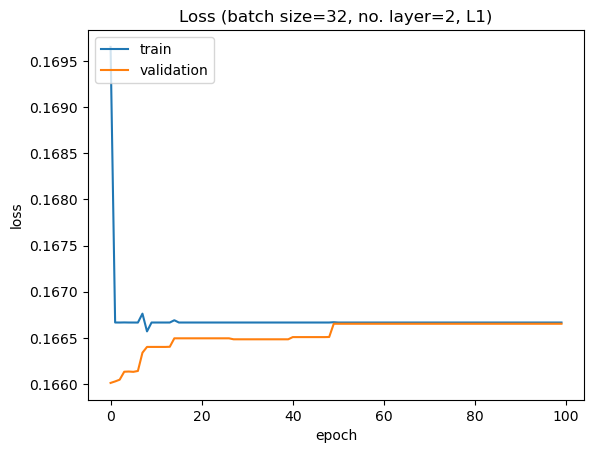

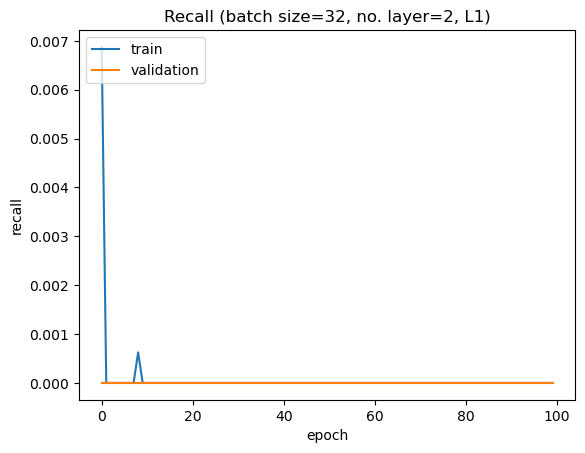

In [54]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [55]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [56]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1708 - accuracy: 0.8275 - recall_11: 0.0106 - val_loss: 0.1652 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 2/100
150/150 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1651 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 3/100
150/150 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1650 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 4/100
150/150 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1654 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 5/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1653 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 6/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1653 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 7/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - v

Epoch 55/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 56/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 57/100
150/150 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 58/100
150/150 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 59/100
150/150 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 60/100
150/150 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 61/100
150/150 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0

#### Predict

In [57]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

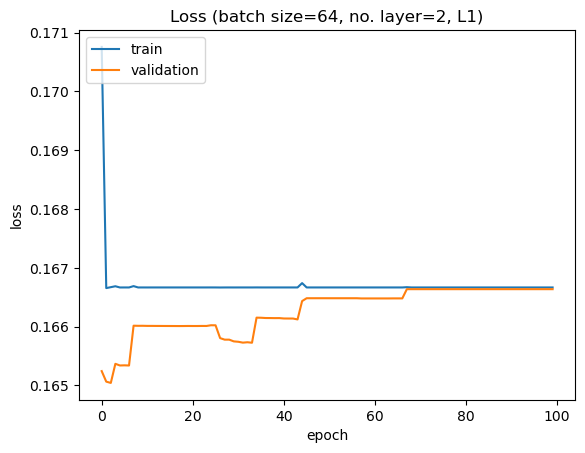

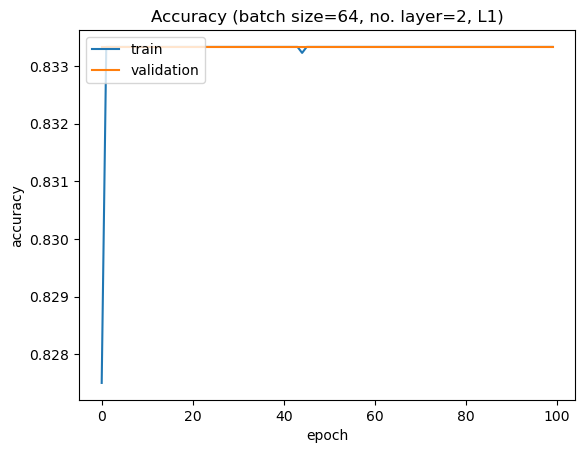

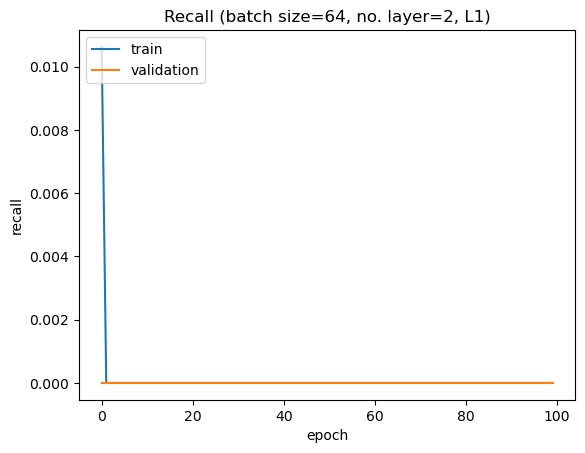

In [58]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [59]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


## densenet

In [60]:
# left_train = np.load('vgg_train_left.npy')
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

left_train = np.load('densenet_train_left.npy')
right_train = np.load('densenet_train_right.npy')
left_test = np.load('densenet_test_left.npy')
right_test = np.load('densenet_test_right.npy')

In [61]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [62]:
# input_shape = (512,)
# input_shape = (2048,)
input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\densenet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\densenet_{}_1_{}.png".format(batch_size, metric)) 
    plt.show()

In [63]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.1672 - accuracy: 0.8301 - recall_12: 0.0037 - val_loss: 0.1649 - val_accuracy: 0.8325 - val_recall_12: 0.0100
Epoch 2/100
600/600 - 1s - loss: 0.1605 - accuracy: 0.8290 - recall_12: 0.0350 - val_loss: 0.1598 - val_accuracy: 0.8329 - val_recall_12: 0.0150
Epoch 3/100
600/600 - 1s - loss: 0.1423 - accuracy: 0.8427 - recall_12: 0.1388 - val_loss: 0.1533 - val_accuracy: 0.8250 - val_recall_12: 0.0600
Epoch 4/100
600/600 - 1s - loss: 0.1232 - accuracy: 0.8616 - recall_12: 0.2444 - val_loss: 0.1509 - val_accuracy: 0.8146 - val_recall_12: 0.0925
Epoch 5/100
600/600 - 1s - loss: 0.1062 - accuracy: 0.8818 - recall_12: 0.3562 - val_loss: 0.1503 - val_accuracy: 0.8146 - val_recall_12: 0.1050
Epoch 6/100
600/600 - 1s - loss: 0.0891 - accuracy: 0.9029 - recall_12: 0.4663 - val_loss: 0.1593 - val_accuracy: 0.7996 - val_recall_12: 0.1450
Epoch 7/100
600/600 - 1s - loss: 0.0768 - accuracy: 0.9177 - recall_12: 0.5450 - val_loss: 0.1684 - val_accuracy: 0.7850 - val_rec

Epoch 58/100
600/600 - 1s - loss: 0.0397 - accuracy: 0.9591 - recall_12: 0.7700 - val_loss: 0.1936 - val_accuracy: 0.8008 - val_recall_12: 0.1275
Epoch 59/100
600/600 - 1s - loss: 0.0390 - accuracy: 0.9602 - recall_12: 0.7756 - val_loss: 0.2074 - val_accuracy: 0.7804 - val_recall_12: 0.1900
Epoch 60/100
600/600 - 1s - loss: 0.0380 - accuracy: 0.9615 - recall_12: 0.7800 - val_loss: 0.1906 - val_accuracy: 0.8012 - val_recall_12: 0.1225
Epoch 61/100
600/600 - 1s - loss: 0.0380 - accuracy: 0.9611 - recall_12: 0.7756 - val_loss: 0.1946 - val_accuracy: 0.7954 - val_recall_12: 0.1425
Epoch 62/100
600/600 - 1s - loss: 0.0371 - accuracy: 0.9625 - recall_12: 0.7825 - val_loss: 0.2095 - val_accuracy: 0.7804 - val_recall_12: 0.2300
Epoch 63/100
600/600 - 1s - loss: 0.0381 - accuracy: 0.9613 - recall_12: 0.7800 - val_loss: 0.1976 - val_accuracy: 0.7908 - val_recall_12: 0.1475
Epoch 64/100
600/600 - 1s - loss: 0.0384 - accuracy: 0.9608 - recall_12: 0.7756 - val_loss: 0.1980 - val_accuracy: 0.7904 - 

#### Predict

In [64]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

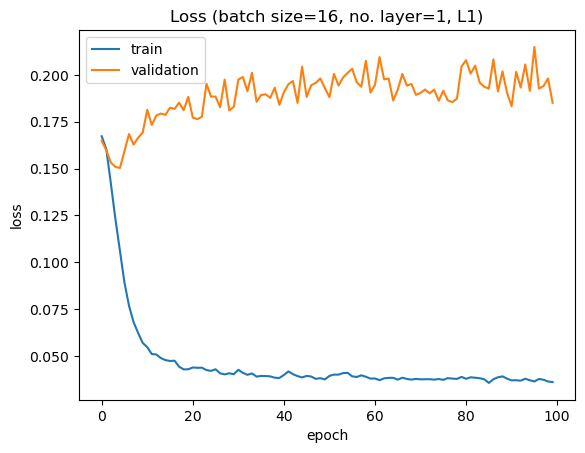

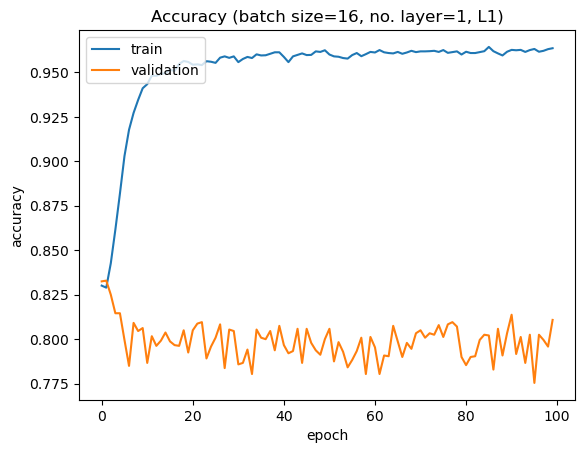

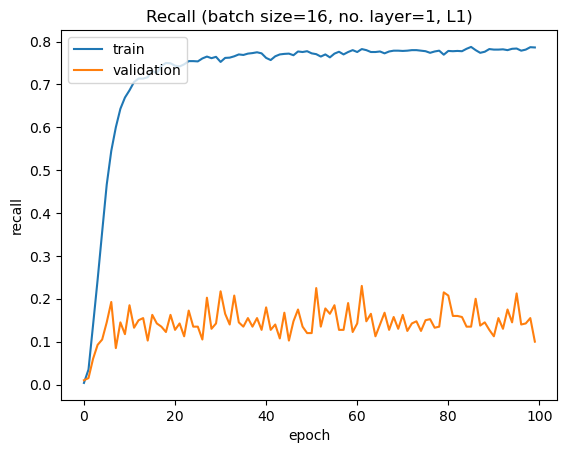

In [65]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [66]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.036
Training Accuracy: 0.964
Training Recall: 0.786


Validation Loss: 0.185
Validation Accuracy: 0.811
Validation Recall: 0.1


### batch size = 32, number of layer = 1

In [67]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1704 - accuracy: 0.8285 - recall_13: 0.0088 - val_loss: 0.1657 - val_accuracy: 0.8329 - val_recall_13: 0.0000e+00
Epoch 2/100
300/300 - 0s - loss: 0.1652 - accuracy: 0.8317 - recall_13: 0.0063 - val_loss: 0.1636 - val_accuracy: 0.8329 - val_recall_13: 0.0075
Epoch 3/100
300/300 - 0s - loss: 0.1571 - accuracy: 0.8344 - recall_13: 0.0512 - val_loss: 0.1619 - val_accuracy: 0.8300 - val_recall_13: 0.0075
Epoch 4/100
300/300 - 0s - loss: 0.1413 - accuracy: 0.8447 - recall_13: 0.1388 - val_loss: 0.1559 - val_accuracy: 0.8192 - val_recall_13: 0.0850
Epoch 5/100
300/300 - 0s - loss: 0.1224 - accuracy: 0.8619 - recall_13: 0.2500 - val_loss: 0.1527 - val_accuracy: 0.8196 - val_recall_13: 0.0825
Epoch 6/100
300/300 - 0s - loss: 0.1020 - accuracy: 0.8866 - recall_13: 0.3781 - val_loss: 0.1501 - val_accuracy: 0.8208 - val_recall_13: 0.0875
Epoch 7/100
300/300 - 0s - loss: 0.0865 - accuracy: 0.9060 - recall_13: 0.4894 - val_loss: 0.1538 - val_accuracy: 0.8263 - val

Epoch 58/100
300/300 - 0s - loss: 0.0273 - accuracy: 0.9723 - recall_13: 0.8406 - val_loss: 0.1976 - val_accuracy: 0.7896 - val_recall_13: 0.1400
Epoch 59/100
300/300 - 1s - loss: 0.0272 - accuracy: 0.9723 - recall_13: 0.8381 - val_loss: 0.2012 - val_accuracy: 0.7825 - val_recall_13: 0.1400
Epoch 60/100
300/300 - 0s - loss: 0.0268 - accuracy: 0.9730 - recall_13: 0.8425 - val_loss: 0.2006 - val_accuracy: 0.7858 - val_recall_13: 0.1425
Epoch 61/100
300/300 - 0s - loss: 0.0269 - accuracy: 0.9725 - recall_13: 0.8394 - val_loss: 0.2067 - val_accuracy: 0.7804 - val_recall_13: 0.1700
Epoch 62/100
300/300 - 0s - loss: 0.0273 - accuracy: 0.9722 - recall_13: 0.8406 - val_loss: 0.2062 - val_accuracy: 0.7833 - val_recall_13: 0.1850
Epoch 63/100
300/300 - 0s - loss: 0.0281 - accuracy: 0.9710 - recall_13: 0.8356 - val_loss: 0.2064 - val_accuracy: 0.7833 - val_recall_13: 0.1725
Epoch 64/100
300/300 - 1s - loss: 0.0284 - accuracy: 0.9710 - recall_13: 0.8381 - val_loss: 0.2134 - val_accuracy: 0.7733 - 

#### Predict

In [68]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

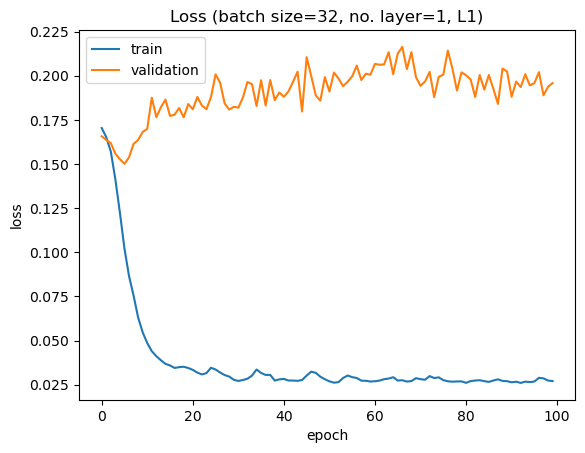

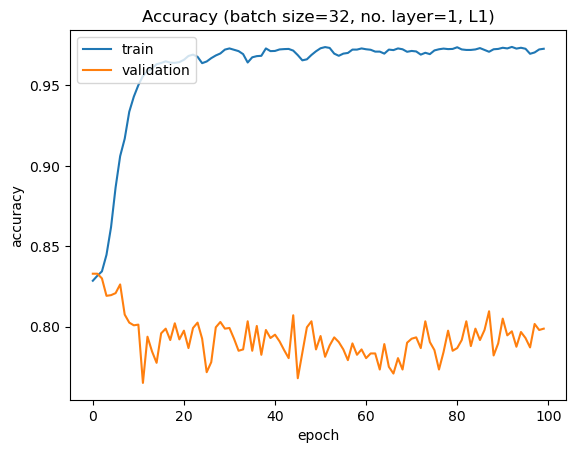

In [69]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [70]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.027
Training Accuracy: 0.973
Training Recall: 0.842


Validation Loss: 0.196
Validation Accuracy: 0.799
Validation Recall: 0.175


### batch size = 64, number of layer = 1

In [71]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1677 - accuracy: 0.8309 - recall_14: 6.2500e-04 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00
Epoch 2/100
150/150 - 0s - loss: 0.1666 - accuracy: 0.8333 - recall_14: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00
Epoch 3/100
150/150 - 0s - loss: 0.1666 - accuracy: 0.8333 - recall_14: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00
Epoch 4/100
150/150 - 0s - loss: 0.1666 - accuracy: 0.8333 - recall_14: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00
Epoch 5/100
150/150 - 0s - loss: 0.1665 - accuracy: 0.8334 - recall_14: 6.2500e-04 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00
Epoch 6/100
150/150 - 0s - loss: 0.1658 - accuracy: 0.8316 - recall_14: 0.0081 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00
Epoch 7/100
150/150 - 0s - loss: 0.1599 - accuracy: 0.8335 - recall_14: 0.0425 - val_l

Epoch 57/100
150/150 - 0s - loss: 0.0416 - accuracy: 0.9551 - recall_14: 0.7650 - val_loss: 0.2006 - val_accuracy: 0.7812 - val_recall_14: 0.1900
Epoch 58/100
150/150 - 0s - loss: 0.0459 - accuracy: 0.9502 - recall_14: 0.7431 - val_loss: 0.1930 - val_accuracy: 0.7937 - val_recall_14: 0.1625
Epoch 59/100
150/150 - 0s - loss: 0.0404 - accuracy: 0.9572 - recall_14: 0.7675 - val_loss: 0.1955 - val_accuracy: 0.7842 - val_recall_14: 0.1325
Epoch 60/100
150/150 - 0s - loss: 0.0362 - accuracy: 0.9629 - recall_14: 0.7887 - val_loss: 0.1953 - val_accuracy: 0.7879 - val_recall_14: 0.1525
Epoch 61/100
150/150 - 0s - loss: 0.0340 - accuracy: 0.9658 - recall_14: 0.7994 - val_loss: 0.1912 - val_accuracy: 0.7917 - val_recall_14: 0.1300
Epoch 62/100
150/150 - 0s - loss: 0.0328 - accuracy: 0.9674 - recall_14: 0.8056 - val_loss: 0.1886 - val_accuracy: 0.7967 - val_recall_14: 0.1425
Epoch 63/100
150/150 - 0s - loss: 0.0323 - accuracy: 0.9677 - recall_14: 0.8081 - val_loss: 0.1872 - val_accuracy: 0.8000 - 

#### Predict

In [72]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

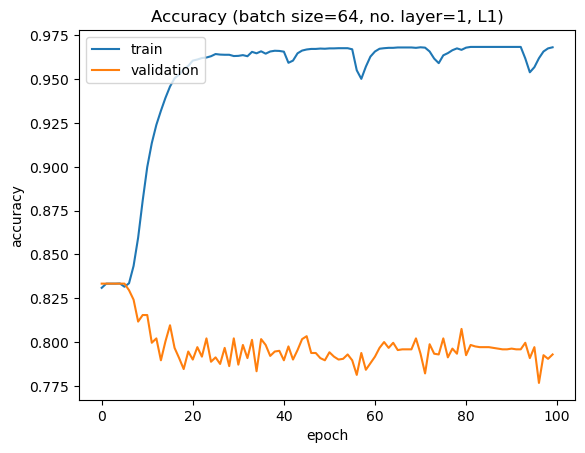

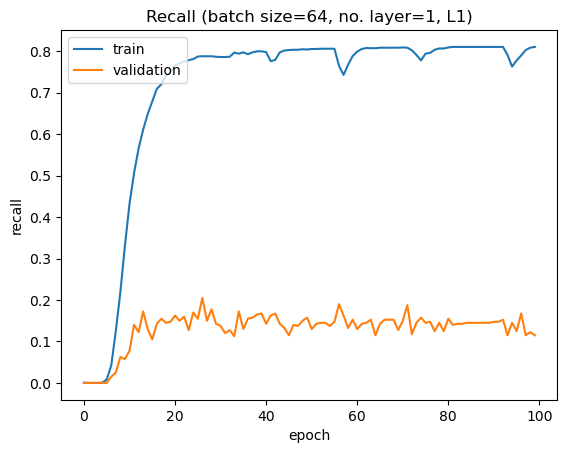

In [73]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [74]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.032
Training Accuracy: 0.968
Training Recall: 0.811


Validation Loss: 0.192
Validation Accuracy: 0.793
Validation Recall: 0.115


### batch size = 16, number of layer = 2

In [75]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\densenet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\densenet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [76]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.1672 - accuracy: 0.8316 - recall_15: 0.0012 - val_loss: 0.1645 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8332 - recall_15: 0.0000e+00 - val_loss: 0.1656 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1656 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1656 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1656 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1656 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - v

Epoch 55/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 56/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 57/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 58/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 59/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 60/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 61/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0

#### Predict

In [77]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

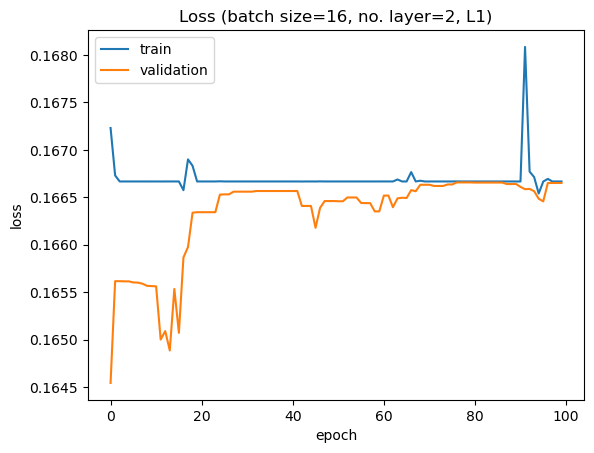

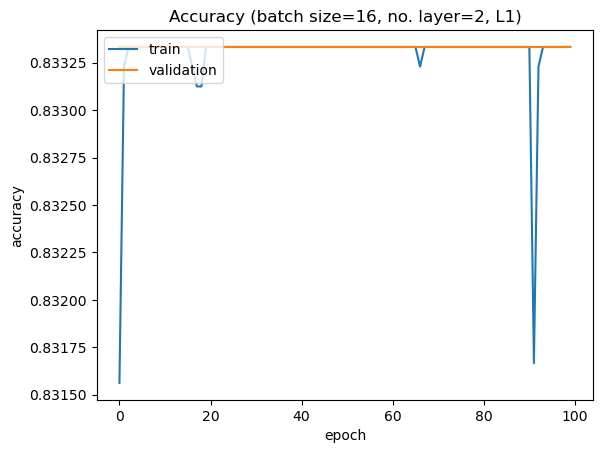

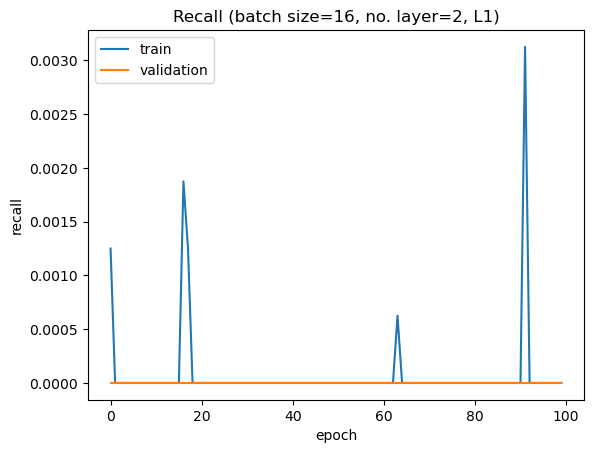

In [78]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [79]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [80]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1692 - accuracy: 0.8292 - recall_16: 0.0063 - val_loss: 0.1658 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 2/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1658 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 3/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1657 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 4/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1658 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 5/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1655 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 6/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1655 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 7/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8332 - recall_16: 0.0000e+00 - v

Epoch 55/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1663 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 56/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1663 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 57/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1663 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 58/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1663 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 59/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1662 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 60/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1662 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 61/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0

#### Predict

In [81]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

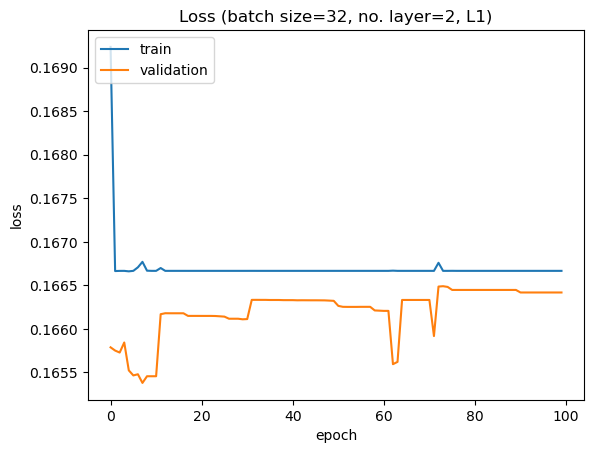

In [82]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [83]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.166
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [84]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1674 - accuracy: 0.8311 - recall_17: 0.0019 - val_loss: 0.1654 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 2/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8330 - recall_17: 6.2500e-04 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 3/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 4/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 5/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 6/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 7/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - v

Epoch 55/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 56/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8332 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 57/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 58/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 59/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 60/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 61/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0

#### Predict

In [85]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

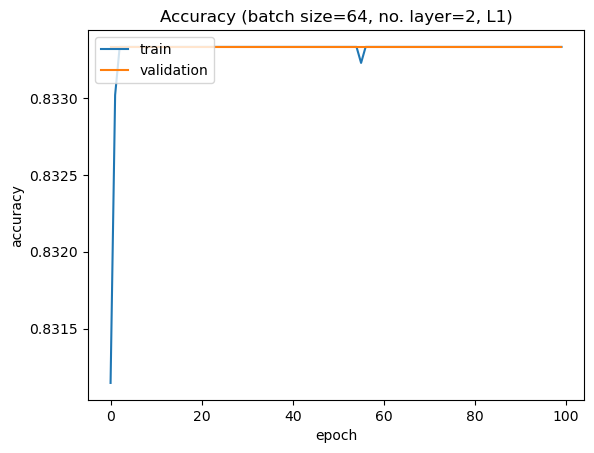

In [86]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [87]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


# L2 Distance

## vgg

In [88]:
left_train = np.load('vgg_train_left.npy')
right_train = np.load('vgg_train_right.npy')
left_test = np.load('vgg_test_left.npy')
right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [89]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [90]:
input_shape = (512,)
# input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model

# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_network(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    shared_network = create_shared_network(input_shape)
    left_features = shared_network(left_input)
    right_features = shared_network(right_input)

#     distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([left_features, right_features])
#     normal_layer = tf.keras.layers.BatchNormalization()(distance)
#     similarity_score = Dense(1, activation='sigmoid')(distance)
    
    distance = Lambda(euclidean_distance)([left_features, right_features])
    normal_layer = tf.keras.layers.BatchNormalization()(distance)
    similarity_score = layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_net = Model(inputs=[left_input, right_input], outputs=1-similarity_score)
    return siamese_net
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\vgg_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\vgg_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [91]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.2340 - accuracy: 0.6649 - recall_18: 0.1525 - val_loss: 0.1716 - val_accuracy: 0.7908 - val_recall_18: 0.0475
Epoch 2/100
600/600 - 1s - loss: 0.1511 - accuracy: 0.8209 - recall_18: 0.0144 - val_loss: 0.1437 - val_accuracy: 0.8329 - val_recall_18: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1396 - accuracy: 0.8333 - recall_18: 0.0000e+00 - val_loss: 0.1405 - val_accuracy: 0.8333 - val_recall_18: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1386 - accuracy: 0.8333 - recall_18: 0.0000e+00 - val_loss: 0.1403 - val_accuracy: 0.8333 - val_recall_18: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1384 - accuracy: 0.8333 - recall_18: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_18: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1379 - accuracy: 0.8333 - recall_18: 0.0000e+00 - val_loss: 0.1422 - val_accuracy: 0.8333 - val_recall_18: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1372 - accuracy: 0.8333 - recall_18: 0.0000e+00 - val_loss:

Epoch 57/100
600/600 - 1s - loss: 0.1064 - accuracy: 0.8682 - recall_18: 0.3631 - val_loss: 0.2275 - val_accuracy: 0.7279 - val_recall_18: 0.0875
Epoch 58/100
600/600 - 1s - loss: 0.1060 - accuracy: 0.8690 - recall_18: 0.3681 - val_loss: 0.2368 - val_accuracy: 0.7225 - val_recall_18: 0.0900
Epoch 59/100
600/600 - 1s - loss: 0.1029 - accuracy: 0.8744 - recall_18: 0.3925 - val_loss: 0.2332 - val_accuracy: 0.7233 - val_recall_18: 0.0950
Epoch 60/100
600/600 - 1s - loss: 0.1044 - accuracy: 0.8697 - recall_18: 0.3694 - val_loss: 0.2449 - val_accuracy: 0.7079 - val_recall_18: 0.1025
Epoch 61/100
600/600 - 1s - loss: 0.1028 - accuracy: 0.8723 - recall_18: 0.3919 - val_loss: 0.2483 - val_accuracy: 0.7021 - val_recall_18: 0.1075
Epoch 62/100
600/600 - 1s - loss: 0.1058 - accuracy: 0.8677 - recall_18: 0.3706 - val_loss: 0.2428 - val_accuracy: 0.7042 - val_recall_18: 0.1025
Epoch 63/100
600/600 - 1s - loss: 0.1027 - accuracy: 0.8728 - recall_18: 0.3906 - val_loss: 0.2480 - val_accuracy: 0.7050 - 

#### Predict

In [92]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

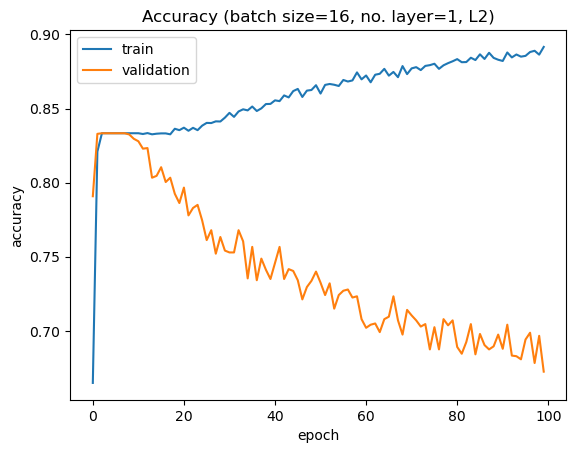

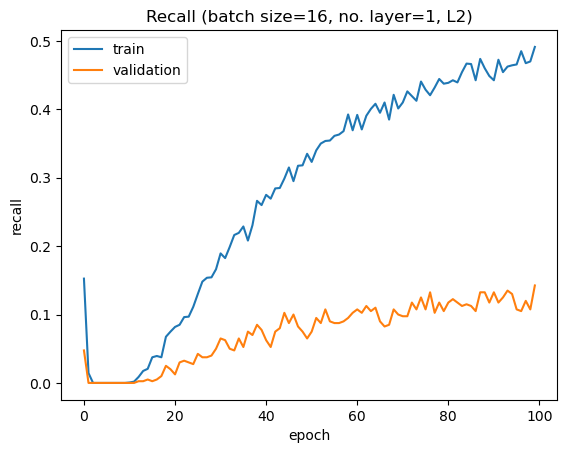

In [93]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [94]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.094
Training Accuracy: 0.892
Training Recall: 0.491


Validation Loss: 0.285
Validation Accuracy: 0.673
Validation Recall: 0.142


### batch size = 32, number of layer = 1

In [95]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.2343 - accuracy: 0.6611 - recall_19: 0.1625 - val_loss: 0.2105 - val_accuracy: 0.7704 - val_recall_19: 0.0625
Epoch 2/100
300/300 - 0s - loss: 0.1881 - accuracy: 0.8060 - recall_19: 0.0350 - val_loss: 0.1732 - val_accuracy: 0.8179 - val_recall_19: 0.0125
Epoch 3/100
300/300 - 0s - loss: 0.1610 - accuracy: 0.8279 - recall_19: 0.0075 - val_loss: 0.1511 - val_accuracy: 0.8321 - val_recall_19: 0.0000e+00
Epoch 4/100
300/300 - 0s - loss: 0.1448 - accuracy: 0.8333 - recall_19: 0.0000e+00 - val_loss: 0.1446 - val_accuracy: 0.8333 - val_recall_19: 0.0000e+00
Epoch 5/100
300/300 - 0s - loss: 0.1381 - accuracy: 0.8333 - recall_19: 0.0000e+00 - val_loss: 0.1435 - val_accuracy: 0.8333 - val_recall_19: 0.0000e+00
Epoch 6/100
300/300 - 0s - loss: 0.1356 - accuracy: 0.8333 - recall_19: 0.0000e+00 - val_loss: 0.1467 - val_accuracy: 0.8325 - val_recall_19: 0.0000e+00
Epoch 7/100
300/300 - 0s - loss: 0.1341 - accuracy: 0.8333 - recall_19: 6.2500e-04 - val_loss: 0.1497 

Epoch 57/100
300/300 - 0s - loss: 0.0732 - accuracy: 0.9189 - recall_19: 0.6094 - val_loss: 0.3078 - val_accuracy: 0.6604 - val_recall_19: 0.1350
Epoch 58/100
300/300 - 0s - loss: 0.0738 - accuracy: 0.9155 - recall_19: 0.6019 - val_loss: 0.3065 - val_accuracy: 0.6579 - val_recall_19: 0.1275
Epoch 59/100
300/300 - 0s - loss: 0.0737 - accuracy: 0.9162 - recall_19: 0.5919 - val_loss: 0.3155 - val_accuracy: 0.6483 - val_recall_19: 0.1475
Epoch 60/100
300/300 - 0s - loss: 0.0721 - accuracy: 0.9179 - recall_19: 0.6006 - val_loss: 0.3034 - val_accuracy: 0.6646 - val_recall_19: 0.1150
Epoch 61/100
300/300 - 0s - loss: 0.0707 - accuracy: 0.9214 - recall_19: 0.6106 - val_loss: 0.3106 - val_accuracy: 0.6600 - val_recall_19: 0.1325
Epoch 62/100
300/300 - 0s - loss: 0.0725 - accuracy: 0.9162 - recall_19: 0.6012 - val_loss: 0.3096 - val_accuracy: 0.6579 - val_recall_19: 0.1300
Epoch 63/100
300/300 - 0s - loss: 0.0712 - accuracy: 0.9218 - recall_19: 0.6200 - val_loss: 0.3159 - val_accuracy: 0.6492 - 

#### Predict

In [96]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

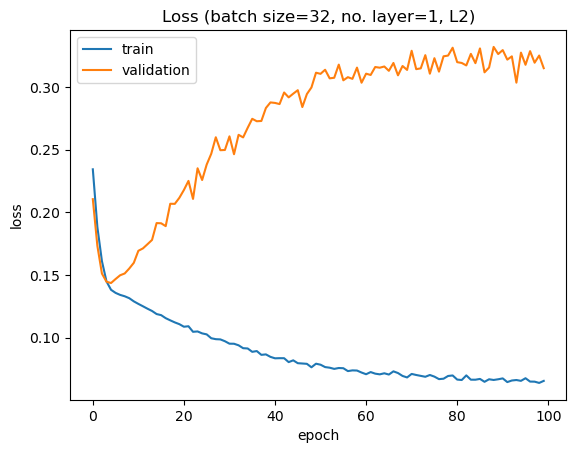

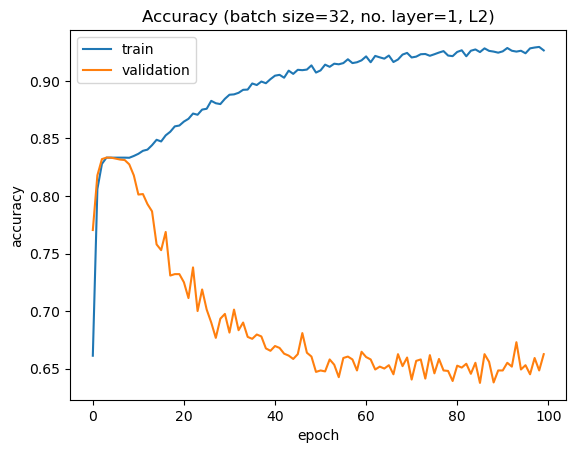

In [97]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [98]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.065
Training Accuracy: 0.927
Training Recall: 0.644


Validation Loss: 0.315
Validation Accuracy: 0.663
Validation Recall: 0.123


### batch size = 64, number of layer = 1

In [99]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 0s - loss: 0.2362 - accuracy: 0.6066 - recall_20: 0.6606 - val_loss: 0.1272 - val_accuracy: 0.8379 - val_recall_20: 0.1650
Epoch 2/100
150/150 - 0s - loss: 0.1742 - accuracy: 0.7557 - recall_20: 0.6762 - val_loss: 0.1529 - val_accuracy: 0.7954 - val_recall_20: 0.4100
Epoch 3/100
150/150 - 0s - loss: 0.1361 - accuracy: 0.8477 - recall_20: 0.6706 - val_loss: 0.1528 - val_accuracy: 0.7900 - val_recall_20: 0.3850
Epoch 4/100
150/150 - 0s - loss: 0.1085 - accuracy: 0.8905 - recall_20: 0.6625 - val_loss: 0.1551 - val_accuracy: 0.7821 - val_recall_20: 0.4050
Epoch 5/100
150/150 - 0s - loss: 0.0859 - accuracy: 0.9197 - recall_20: 0.7088 - val_loss: 0.1376 - val_accuracy: 0.8104 - val_recall_20: 0.2850
Epoch 6/100
150/150 - 0s - loss: 0.0676 - accuracy: 0.9384 - recall_20: 0.7638 - val_loss: 0.1389 - val_accuracy: 0.8133 - val_recall_20: 0.2775
Epoch 7/100
150/150 - 0s - loss: 0.0513 - accuracy: 0.9585 - recall_20: 0.8462 - val_loss: 0.1376 - val_accuracy: 0.8108 - val_rec

Epoch 58/100
150/150 - 0s - loss: 0.0036 - accuracy: 0.9959 - recall_20: 0.9862 - val_loss: 0.1799 - val_accuracy: 0.7946 - val_recall_20: 0.3300
Epoch 59/100
150/150 - 0s - loss: 0.0030 - accuracy: 0.9965 - recall_20: 0.9850 - val_loss: 0.1669 - val_accuracy: 0.8100 - val_recall_20: 0.2925
Epoch 60/100
150/150 - 0s - loss: 0.0042 - accuracy: 0.9950 - recall_20: 0.9837 - val_loss: 0.1715 - val_accuracy: 0.8092 - val_recall_20: 0.3125
Epoch 61/100
150/150 - 0s - loss: 0.0040 - accuracy: 0.9956 - recall_20: 0.9850 - val_loss: 0.1709 - val_accuracy: 0.8042 - val_recall_20: 0.2725
Epoch 62/100
150/150 - 0s - loss: 0.0033 - accuracy: 0.9960 - recall_20: 0.9862 - val_loss: 0.1663 - val_accuracy: 0.8100 - val_recall_20: 0.2825
Epoch 63/100
150/150 - 0s - loss: 0.0032 - accuracy: 0.9965 - recall_20: 0.9906 - val_loss: 0.1719 - val_accuracy: 0.8000 - val_recall_20: 0.2775
Epoch 64/100
150/150 - 0s - loss: 0.0028 - accuracy: 0.9970 - recall_20: 0.9900 - val_loss: 0.1736 - val_accuracy: 0.8046 - 

#### Predict

In [100]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

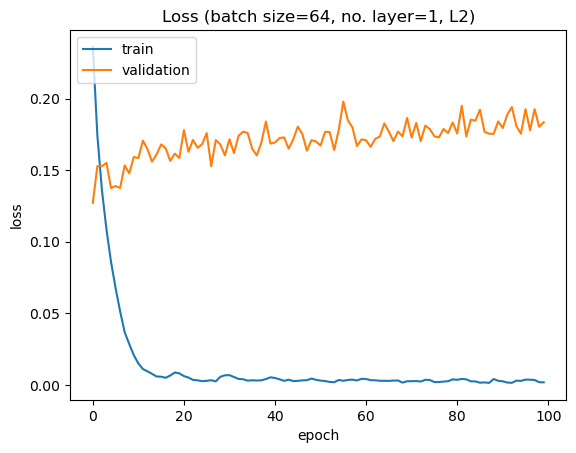

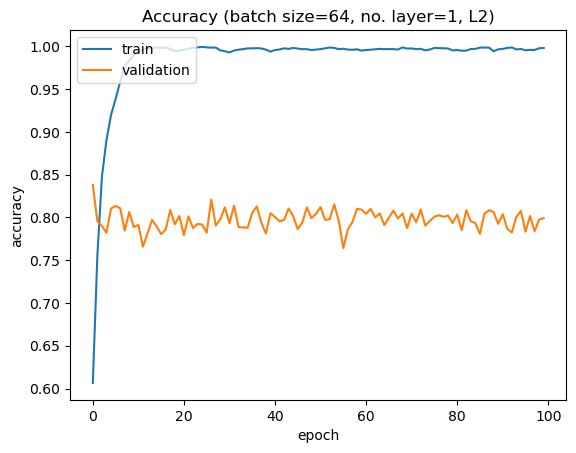

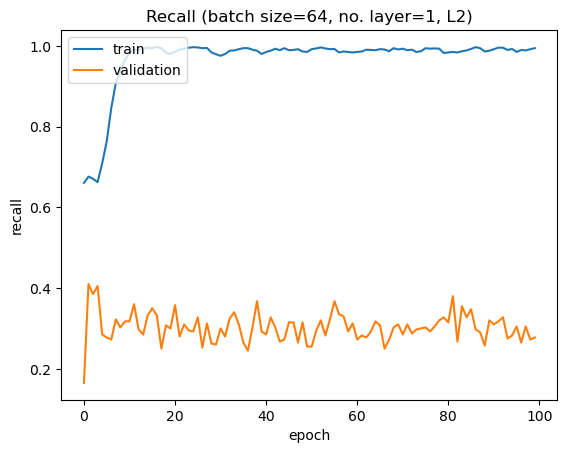

In [101]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [102]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.002
Training Accuracy: 0.998
Training Recall: 0.994


Validation Loss: 0.184
Validation Accuracy: 0.799
Validation Recall: 0.278


### batch size = 16, number of layer = 2

In [103]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),
        
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model

def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\vgg_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\vgg_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [104]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.2197 - accuracy: 0.6705 - recall_21: 0.2206 - val_loss: 0.1458 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1505 - accuracy: 0.8300 - recall_21: 0.0037 - val_loss: 0.1423 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1402 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1392 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1392 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1390 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_l

Epoch 55/100
600/600 - 1s - loss: 0.1261 - accuracy: 0.8335 - recall_21: 0.0194 - val_loss: 0.1348 - val_accuracy: 0.8346 - val_recall_21: 0.0100
Epoch 56/100
600/600 - 1s - loss: 0.1261 - accuracy: 0.8332 - recall_21: 0.0194 - val_loss: 0.1340 - val_accuracy: 0.8338 - val_recall_21: 0.0025
Epoch 57/100
600/600 - 1s - loss: 0.1253 - accuracy: 0.8339 - recall_21: 0.0188 - val_loss: 0.1361 - val_accuracy: 0.8321 - val_recall_21: 0.0150
Epoch 58/100
600/600 - 1s - loss: 0.1249 - accuracy: 0.8358 - recall_21: 0.0312 - val_loss: 0.1374 - val_accuracy: 0.8267 - val_recall_21: 0.0250
Epoch 59/100
600/600 - 1s - loss: 0.1256 - accuracy: 0.8349 - recall_21: 0.0344 - val_loss: 0.1346 - val_accuracy: 0.8338 - val_recall_21: 0.0100
Epoch 60/100
600/600 - 1s - loss: 0.1263 - accuracy: 0.8333 - recall_21: 0.0200 - val_loss: 0.1349 - val_accuracy: 0.8304 - val_recall_21: 0.0100
Epoch 61/100
600/600 - 1s - loss: 0.1250 - accuracy: 0.8324 - recall_21: 0.0175 - val_loss: 0.1345 - val_accuracy: 0.8313 - 

#### Predict

In [105]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

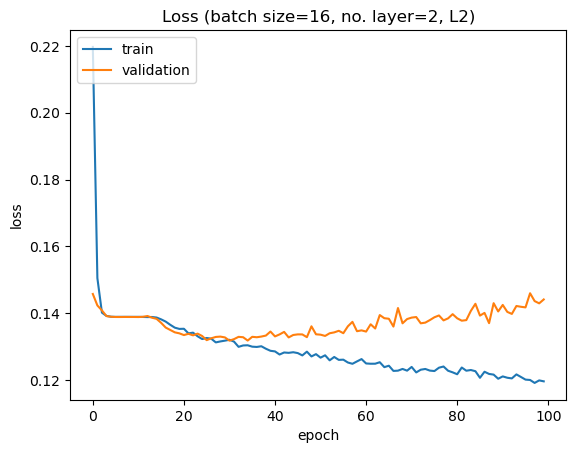

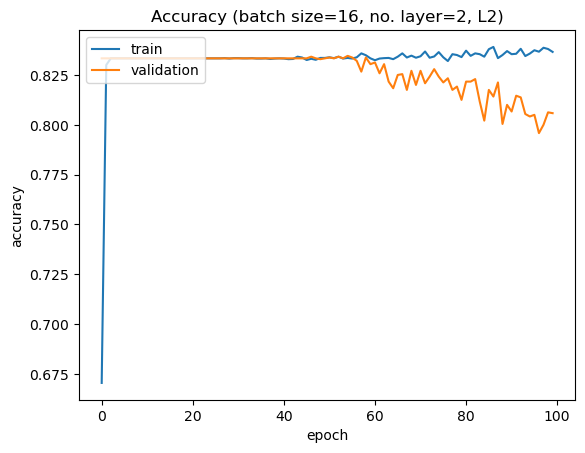

In [106]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [107]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.12
Training Accuracy: 0.837
Training Recall: 0.094


Validation Loss: 0.144
Validation Accuracy: 0.806
Validation Recall: 0.177


### batch size = 32, number of layer = 2

In [108]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.2469 - accuracy: 0.6121 - recall_22: 0.2869 - val_loss: 0.1434 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 2/100
300/300 - 0s - loss: 0.1841 - accuracy: 0.7656 - recall_22: 0.0944 - val_loss: 0.1403 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 3/100
300/300 - 1s - loss: 0.1553 - accuracy: 0.8276 - recall_22: 0.0056 - val_loss: 0.1420 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 4/100
300/300 - 1s - loss: 0.1445 - accuracy: 0.8332 - recall_22: 0.0000e+00 - val_loss: 0.1414 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 5/100
300/300 - 1s - loss: 0.1404 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1405 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 6/100
300/300 - 1s - loss: 0.1393 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1399 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 7/100
300/300 - 1s - loss: 0.1390 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss:

Epoch 56/100
300/300 - 1s - loss: 0.1219 - accuracy: 0.8347 - recall_22: 0.0431 - val_loss: 0.1369 - val_accuracy: 0.8150 - val_recall_22: 0.0975
Epoch 57/100
300/300 - 1s - loss: 0.1218 - accuracy: 0.8343 - recall_22: 0.0525 - val_loss: 0.1372 - val_accuracy: 0.8129 - val_recall_22: 0.0950
Epoch 58/100
300/300 - 1s - loss: 0.1216 - accuracy: 0.8377 - recall_22: 0.0688 - val_loss: 0.1391 - val_accuracy: 0.8079 - val_recall_22: 0.1175
Epoch 59/100
300/300 - 1s - loss: 0.1233 - accuracy: 0.8357 - recall_22: 0.0538 - val_loss: 0.1370 - val_accuracy: 0.8183 - val_recall_22: 0.0850
Epoch 60/100
300/300 - 1s - loss: 0.1209 - accuracy: 0.8394 - recall_22: 0.0819 - val_loss: 0.1364 - val_accuracy: 0.8179 - val_recall_22: 0.1075
Epoch 61/100
300/300 - 1s - loss: 0.1208 - accuracy: 0.8365 - recall_22: 0.0750 - val_loss: 0.1396 - val_accuracy: 0.8067 - val_recall_22: 0.1275
Epoch 62/100
300/300 - 0s - loss: 0.1204 - accuracy: 0.8371 - recall_22: 0.0838 - val_loss: 0.1419 - val_accuracy: 0.8037 - 

#### Predict

In [109]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

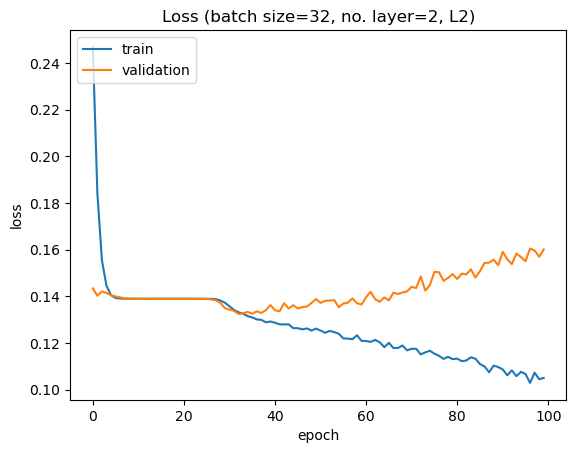

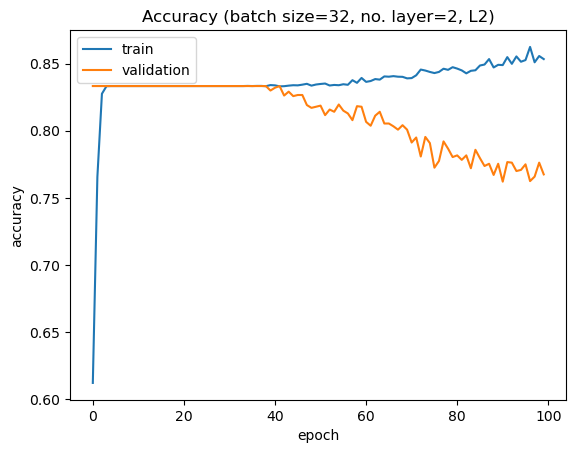

In [110]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [111]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.105
Training Accuracy: 0.853
Training Recall: 0.293


Validation Loss: 0.16
Validation Accuracy: 0.767
Validation Recall: 0.308


### batch size = 64, number of layer = 2

In [112]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.2397 - accuracy: 0.6243 - recall_23: 0.3069 - val_loss: 0.1779 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 2/100
150/150 - 0s - loss: 0.2144 - accuracy: 0.7795 - recall_23: 0.0831 - val_loss: 0.1589 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 3/100
150/150 - 0s - loss: 0.1940 - accuracy: 0.8142 - recall_23: 0.0288 - val_loss: 0.1454 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 4/100
150/150 - 0s - loss: 0.1752 - accuracy: 0.8306 - recall_23: 0.0075 - val_loss: 0.1402 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 5/100
150/150 - 0s - loss: 0.1582 - accuracy: 0.8332 - recall_23: 0.0000e+00 - val_loss: 0.1394 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 6/100
150/150 - 0s - loss: 0.1474 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1393 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 7/100
150/150 - 0s - loss: 0.1423 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1

Epoch 55/100
150/150 - 0s - loss: 0.1327 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1319 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 56/100
150/150 - 0s - loss: 0.1327 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1318 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 57/100
150/150 - 0s - loss: 0.1320 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1325 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 58/100
150/150 - 0s - loss: 0.1315 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1322 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 59/100
150/150 - 0s - loss: 0.1313 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1311 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 60/100
150/150 - 0s - loss: 0.1309 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1311 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 61/100
150/150 - 0s - loss: 0.1307 - accuracy: 0.8333 - recall_23: 0.0

#### Predict

In [113]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

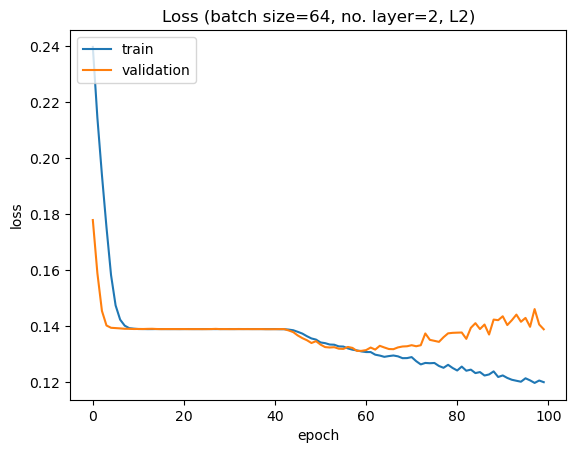

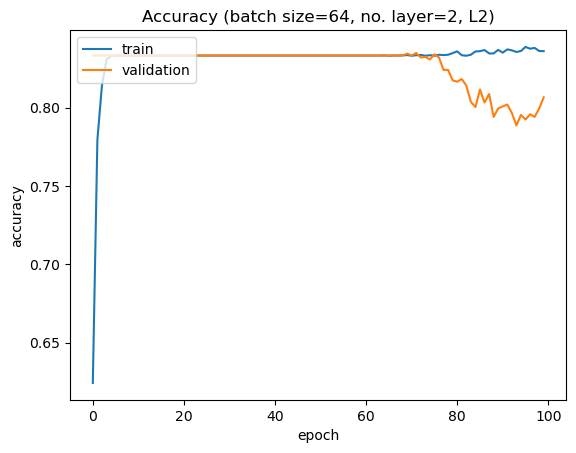

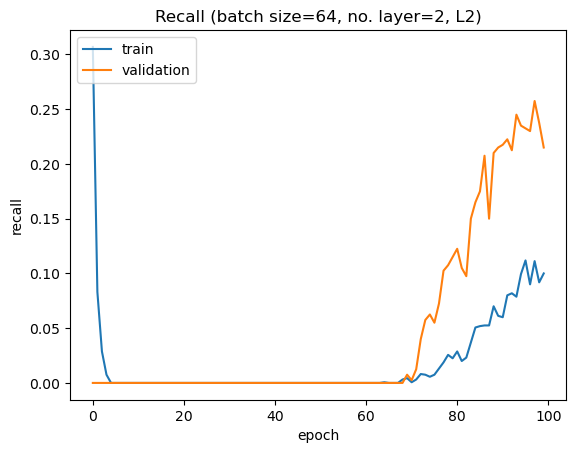

In [114]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [115]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.12
Training Accuracy: 0.836
Training Recall: 0.1


Validation Loss: 0.139
Validation Accuracy: 0.807
Validation Recall: 0.215


## resnet

In [116]:
# left_train = np.load('vgg_train_left.npy')
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

left_train = np.load('resnet_train_left.npy')
right_train = np.load('resnet_train_right.npy')
left_test = np.load('resnet_test_left.npy')
right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [117]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [118]:
# input_shape = (512,)
input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\resnet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\resnet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [119]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2034 - accuracy: 0.6908 - recall_24: 0.4375 - val_loss: 0.1398 - val_accuracy: 0.8267 - val_recall_24: 0.0900
Epoch 2/100
600/600 - 2s - loss: 0.1287 - accuracy: 0.8356 - recall_24: 0.0819 - val_loss: 0.1318 - val_accuracy: 0.8317 - val_recall_24: 0.0150
Epoch 3/100
600/600 - 2s - loss: 0.1192 - accuracy: 0.8381 - recall_24: 0.0725 - val_loss: 0.1302 - val_accuracy: 0.8350 - val_recall_24: 0.0600
Epoch 4/100
600/600 - 2s - loss: 0.1121 - accuracy: 0.8492 - recall_24: 0.1737 - val_loss: 0.1345 - val_accuracy: 0.8233 - val_recall_24: 0.1125
Epoch 5/100
600/600 - 2s - loss: 0.1041 - accuracy: 0.8623 - recall_24: 0.2944 - val_loss: 0.1367 - val_accuracy: 0.8246 - val_recall_24: 0.1100
Epoch 6/100
600/600 - 2s - loss: 0.0911 - accuracy: 0.8818 - recall_24: 0.4200 - val_loss: 0.1404 - val_accuracy: 0.8221 - val_recall_24: 0.1750
Epoch 7/100
600/600 - 2s - loss: 0.0799 - accuracy: 0.8999 - recall_24: 0.5412 - val_loss: 0.1500 - val_accuracy: 0.8062 - val_rec

Epoch 58/100
600/600 - 2s - loss: 0.0196 - accuracy: 0.9761 - recall_24: 0.9156 - val_loss: 0.2081 - val_accuracy: 0.7567 - val_recall_24: 0.2400
Epoch 59/100
600/600 - 2s - loss: 0.0225 - accuracy: 0.9710 - recall_24: 0.9081 - val_loss: 0.1919 - val_accuracy: 0.7825 - val_recall_24: 0.2025
Epoch 60/100
600/600 - 2s - loss: 0.0221 - accuracy: 0.9714 - recall_24: 0.9081 - val_loss: 0.1962 - val_accuracy: 0.7767 - val_recall_24: 0.2450
Epoch 61/100
600/600 - 2s - loss: 0.0215 - accuracy: 0.9726 - recall_24: 0.9194 - val_loss: 0.1844 - val_accuracy: 0.7879 - val_recall_24: 0.1750
Epoch 62/100
600/600 - 2s - loss: 0.0197 - accuracy: 0.9747 - recall_24: 0.9144 - val_loss: 0.1860 - val_accuracy: 0.7842 - val_recall_24: 0.2075
Epoch 63/100
600/600 - 2s - loss: 0.0183 - accuracy: 0.9771 - recall_24: 0.9237 - val_loss: 0.1821 - val_accuracy: 0.7921 - val_recall_24: 0.1925
Epoch 64/100
600/600 - 2s - loss: 0.0193 - accuracy: 0.9759 - recall_24: 0.9250 - val_loss: 0.1876 - val_accuracy: 0.7867 - 

#### Predict

In [120]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

In [121]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [122]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.017
Training Accuracy: 0.979
Training Recall: 0.927


Validation Loss: 0.185
Validation Accuracy: 0.79
Validation Recall: 0.215


### batch size = 32, number of layer = 1

In [123]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.2184 - accuracy: 0.6840 - recall_25: 0.4406 - val_loss: 0.1695 - val_accuracy: 0.8154 - val_recall_25: 0.1600
Epoch 2/100
300/300 - 1s - loss: 0.1638 - accuracy: 0.8215 - recall_25: 0.2825 - val_loss: 0.1426 - val_accuracy: 0.8325 - val_recall_25: 0.1100
Epoch 3/100
300/300 - 1s - loss: 0.1281 - accuracy: 0.8486 - recall_25: 0.2250 - val_loss: 0.1399 - val_accuracy: 0.8213 - val_recall_25: 0.1075
Epoch 4/100
300/300 - 1s - loss: 0.1070 - accuracy: 0.8657 - recall_25: 0.2931 - val_loss: 0.1375 - val_accuracy: 0.8246 - val_recall_25: 0.1450
Epoch 5/100
300/300 - 1s - loss: 0.0888 - accuracy: 0.8916 - recall_25: 0.4475 - val_loss: 0.1395 - val_accuracy: 0.8213 - val_recall_25: 0.1800
Epoch 6/100
300/300 - 1s - loss: 0.0732 - accuracy: 0.9133 - recall_25: 0.5813 - val_loss: 0.1490 - val_accuracy: 0.8021 - val_recall_25: 0.1750
Epoch 7/100
300/300 - 1s - loss: 0.0590 - accuracy: 0.9327 - recall_25: 0.7100 - val_loss: 0.1601 - val_accuracy: 0.7767 - val_rec

Epoch 58/100
300/300 - 1s - loss: 0.0084 - accuracy: 0.9897 - recall_25: 0.9594 - val_loss: 0.1927 - val_accuracy: 0.7796 - val_recall_25: 0.2275
Epoch 59/100
300/300 - 1s - loss: 0.0091 - accuracy: 0.9896 - recall_25: 0.9644 - val_loss: 0.1879 - val_accuracy: 0.7892 - val_recall_25: 0.2150
Epoch 60/100
300/300 - 1s - loss: 0.0083 - accuracy: 0.9903 - recall_25: 0.9675 - val_loss: 0.1771 - val_accuracy: 0.8054 - val_recall_25: 0.1875
Epoch 61/100
300/300 - 1s - loss: 0.0089 - accuracy: 0.9900 - recall_25: 0.9638 - val_loss: 0.1772 - val_accuracy: 0.8071 - val_recall_25: 0.1800
Epoch 62/100
300/300 - 1s - loss: 0.0086 - accuracy: 0.9897 - recall_25: 0.9606 - val_loss: 0.1918 - val_accuracy: 0.7850 - val_recall_25: 0.2250
Epoch 63/100
300/300 - 1s - loss: 0.0093 - accuracy: 0.9890 - recall_25: 0.9669 - val_loss: 0.1835 - val_accuracy: 0.7929 - val_recall_25: 0.2200
Epoch 64/100
300/300 - 1s - loss: 0.0104 - accuracy: 0.9865 - recall_25: 0.9488 - val_loss: 0.1885 - val_accuracy: 0.7862 - 

#### Predict

In [124]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

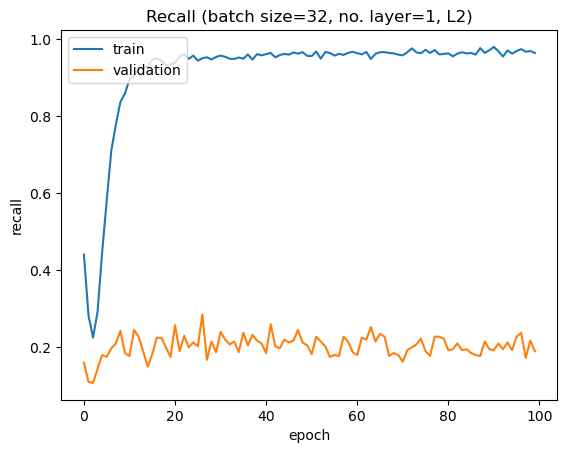

In [125]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [126]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.007
Training Accuracy: 0.991
Training Recall: 0.964


Validation Loss: 0.178
Validation Accuracy: 0.807
Validation Recall: 0.19


### batch size = 64, number of layer = 1

In [127]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.2521 - accuracy: 0.6208 - recall_26: 0.2262 - val_loss: 0.2616 - val_accuracy: 0.6196 - val_recall_26: 0.2575
Epoch 2/100
150/150 - 1s - loss: 0.2139 - accuracy: 0.7511 - recall_26: 0.1100 - val_loss: 0.2103 - val_accuracy: 0.7654 - val_recall_26: 0.0950
Epoch 3/100
150/150 - 1s - loss: 0.1898 - accuracy: 0.7881 - recall_26: 0.0694 - val_loss: 0.1830 - val_accuracy: 0.8071 - val_recall_26: 0.0275
Epoch 4/100
150/150 - 1s - loss: 0.1703 - accuracy: 0.8083 - recall_26: 0.0487 - val_loss: 0.1728 - val_accuracy: 0.8142 - val_recall_26: 0.0250
Epoch 5/100
150/150 - 1s - loss: 0.1543 - accuracy: 0.8217 - recall_26: 0.0331 - val_loss: 0.1566 - val_accuracy: 0.8304 - val_recall_26: 0.0050
Epoch 6/100
150/150 - 1s - loss: 0.1429 - accuracy: 0.8285 - recall_26: 0.0150 - val_loss: 0.1497 - val_accuracy: 0.8321 - val_recall_26: 0.0000e+00
Epoch 7/100
150/150 - 1s - loss: 0.1349 - accuracy: 0.8320 - recall_26: 0.0106 - val_loss: 0.1545 - val_accuracy: 0.8279 - val

Epoch 58/100
150/150 - 1s - loss: 0.0236 - accuracy: 0.9757 - recall_26: 0.8800 - val_loss: 0.3161 - val_accuracy: 0.6496 - val_recall_26: 0.1350
Epoch 59/100
150/150 - 1s - loss: 0.0255 - accuracy: 0.9730 - recall_26: 0.8694 - val_loss: 0.3016 - val_accuracy: 0.6687 - val_recall_26: 0.1250
Epoch 60/100
150/150 - 1s - loss: 0.0275 - accuracy: 0.9704 - recall_26: 0.8631 - val_loss: 0.3220 - val_accuracy: 0.6438 - val_recall_26: 0.1500
Epoch 61/100
150/150 - 1s - loss: 0.0268 - accuracy: 0.9712 - recall_26: 0.8694 - val_loss: 0.3019 - val_accuracy: 0.6675 - val_recall_26: 0.1225
Epoch 62/100
150/150 - 0s - loss: 0.0275 - accuracy: 0.9697 - recall_26: 0.8606 - val_loss: 0.2996 - val_accuracy: 0.6712 - val_recall_26: 0.1350
Epoch 63/100
150/150 - 0s - loss: 0.0263 - accuracy: 0.9735 - recall_26: 0.8712 - val_loss: 0.3012 - val_accuracy: 0.6687 - val_recall_26: 0.1075
Epoch 64/100
150/150 - 1s - loss: 0.0268 - accuracy: 0.9715 - recall_26: 0.8681 - val_loss: 0.2954 - val_accuracy: 0.6758 - 

#### Predict

In [128]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

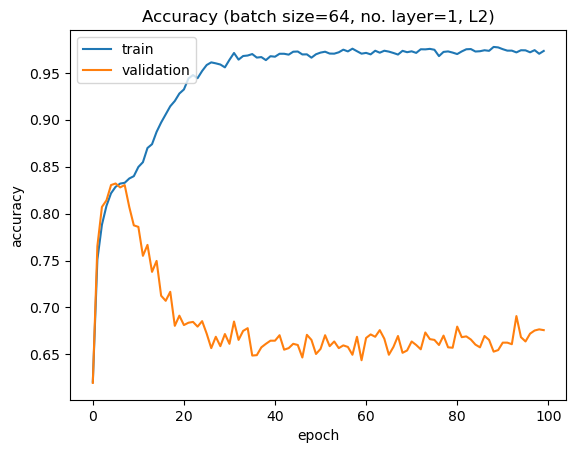

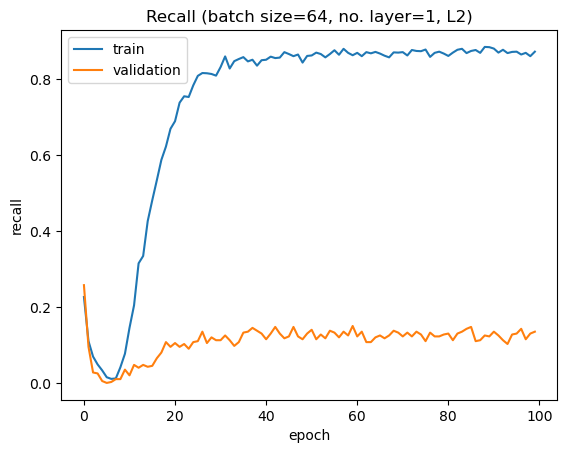

In [129]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [130]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.024
Training Accuracy: 0.973
Training Recall: 0.873


Validation Loss: 0.298
Validation Accuracy: 0.676
Validation Recall: 0.135


### batch size = 16, number of layer = 2

In [131]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\resnet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\resnet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [132]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2180 - accuracy: 0.6827 - recall_27: 0.2169 - val_loss: 0.1457 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 2/100
600/600 - 2s - loss: 0.1499 - accuracy: 0.8305 - recall_27: 0.0025 - val_loss: 0.1429 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 3/100
600/600 - 2s - loss: 0.1403 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 4/100
600/600 - 2s - loss: 0.1391 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1394 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 5/100
600/600 - 2s - loss: 0.1390 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 6/100
600/600 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 7/100
600/600 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_l

Epoch 55/100
600/600 - 2s - loss: 0.1288 - accuracy: 0.8335 - recall_27: 0.0044 - val_loss: 0.1463 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 56/100
600/600 - 2s - loss: 0.1286 - accuracy: 0.8327 - recall_27: 0.0025 - val_loss: 0.1450 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 57/100
600/600 - 2s - loss: 0.1271 - accuracy: 0.8331 - recall_27: 0.0044 - val_loss: 0.1475 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 58/100
600/600 - 2s - loss: 0.1287 - accuracy: 0.8325 - recall_27: 0.0056 - val_loss: 0.1459 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 59/100
600/600 - 2s - loss: 0.1278 - accuracy: 0.8328 - recall_27: 0.0056 - val_loss: 0.1471 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 60/100
600/600 - 2s - loss: 0.1272 - accuracy: 0.8324 - recall_27: 0.0037 - val_loss: 0.1448 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 61/100
600/600 - 2s - loss: 0.1282 - accuracy: 0.8325 - recall_27: 0.0056 - val_loss: 0.1458 -

#### Predict

In [133]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

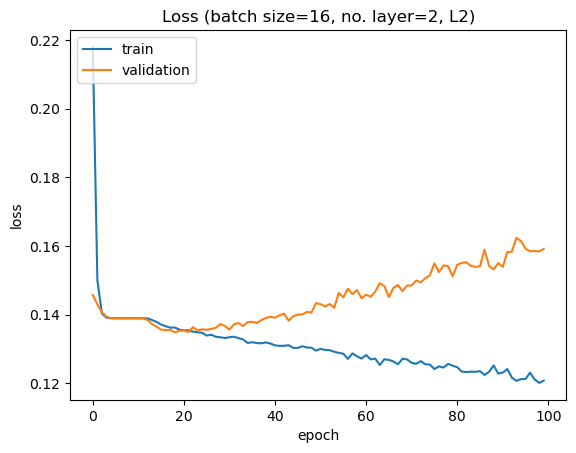

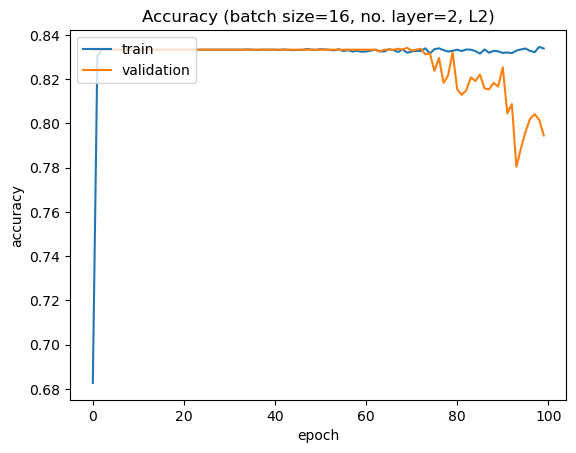

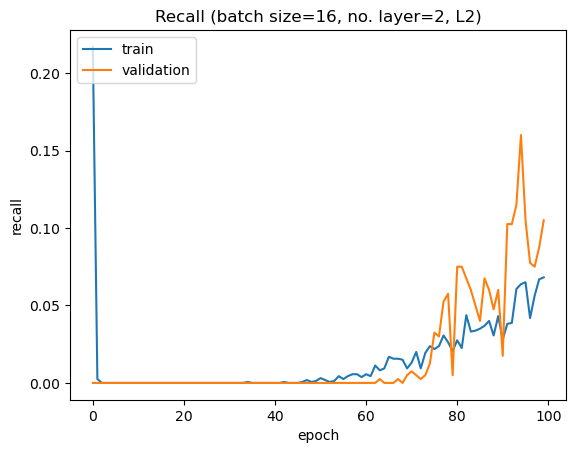

In [134]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [135]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.121
Training Accuracy: 0.834
Training Recall: 0.068


Validation Loss: 0.159
Validation Accuracy: 0.795
Validation Recall: 0.105


### batch size = 32, number of layer = 2

In [136]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 2s - loss: 0.2255 - accuracy: 0.7646 - recall_28: 0.1350 - val_loss: 0.2221 - val_accuracy: 0.7688 - val_recall_28: 0.2825
Epoch 2/100
300/300 - 1s - loss: 0.1789 - accuracy: 0.8333 - recall_28: 0.0019 - val_loss: 0.1712 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 3/100
300/300 - 1s - loss: 0.1477 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1418 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 4/100
300/300 - 1s - loss: 0.1377 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1368 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 5/100
300/300 - 1s - loss: 0.1357 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1355 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 6/100
300/300 - 1s - loss: 0.1351 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1352 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 7/100
300/300 - 1s - loss: 0.1349 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss:

Epoch 57/100
300/300 - 1s - loss: 0.1127 - accuracy: 0.8460 - recall_28: 0.2006 - val_loss: 0.1599 - val_accuracy: 0.7792 - val_recall_28: 0.1575
Epoch 58/100
300/300 - 1s - loss: 0.1116 - accuracy: 0.8472 - recall_28: 0.2025 - val_loss: 0.1624 - val_accuracy: 0.7708 - val_recall_28: 0.1750
Epoch 59/100
300/300 - 1s - loss: 0.1092 - accuracy: 0.8476 - recall_28: 0.2406 - val_loss: 0.1640 - val_accuracy: 0.7700 - val_recall_28: 0.1625
Epoch 60/100
300/300 - 1s - loss: 0.1106 - accuracy: 0.8461 - recall_28: 0.2256 - val_loss: 0.1662 - val_accuracy: 0.7617 - val_recall_28: 0.2200
Epoch 61/100
300/300 - 1s - loss: 0.1122 - accuracy: 0.8495 - recall_28: 0.2325 - val_loss: 0.1646 - val_accuracy: 0.7696 - val_recall_28: 0.1750
Epoch 62/100
300/300 - 1s - loss: 0.1105 - accuracy: 0.8459 - recall_28: 0.2219 - val_loss: 0.1727 - val_accuracy: 0.7467 - val_recall_28: 0.2300
Epoch 63/100
300/300 - 1s - loss: 0.1096 - accuracy: 0.8470 - recall_28: 0.2488 - val_loss: 0.1649 - val_accuracy: 0.7658 - 

#### Predict

In [137]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

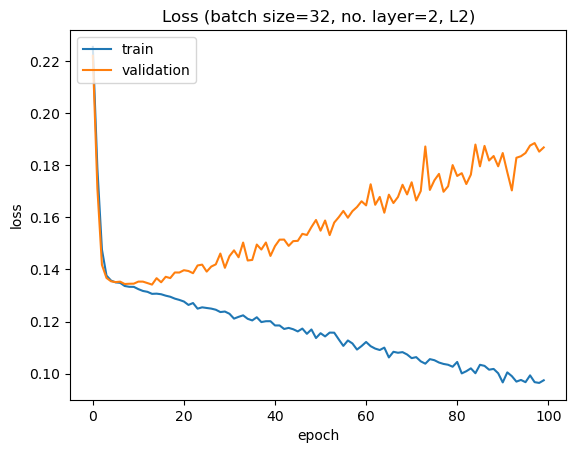

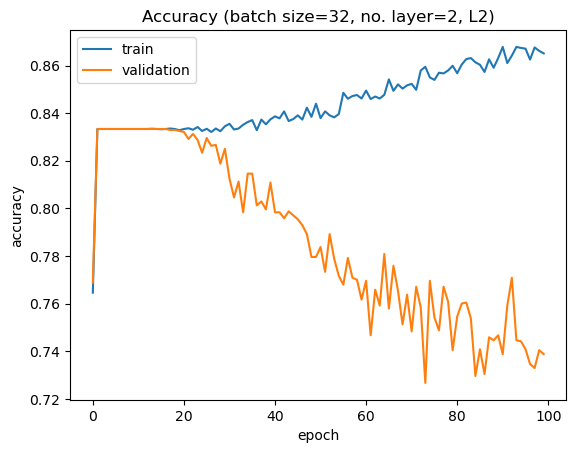

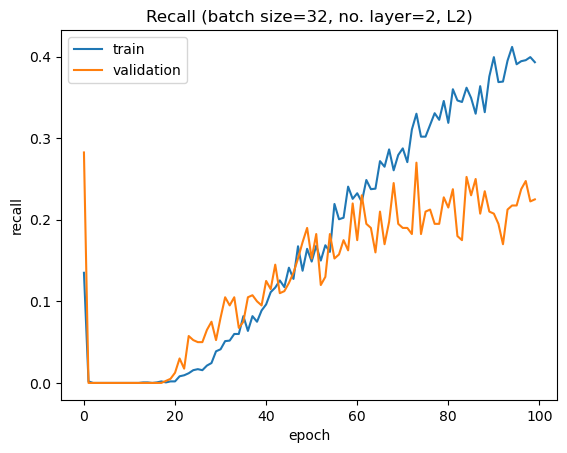

In [138]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [139]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.097
Training Accuracy: 0.865
Training Recall: 0.393


Validation Loss: 0.187
Validation Accuracy: 0.739
Validation Recall: 0.225


### batch size = 64, number of layer = 2

In [140]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 2s - loss: 0.2416 - accuracy: 0.5427 - recall_29: 0.4831 - val_loss: 0.2492 - val_accuracy: 0.4879 - val_recall_29: 0.7125
Epoch 2/100
150/150 - 1s - loss: 0.2088 - accuracy: 0.7274 - recall_29: 0.2338 - val_loss: 0.2195 - val_accuracy: 0.6300 - val_recall_29: 0.5275
Epoch 3/100
150/150 - 1s - loss: 0.1851 - accuracy: 0.8242 - recall_29: 0.0381 - val_loss: 0.1913 - val_accuracy: 0.7900 - val_recall_29: 0.1550
Epoch 4/100
150/150 - 0s - loss: 0.1657 - accuracy: 0.8332 - recall_29: 0.0019 - val_loss: 0.1686 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 5/100
150/150 - 1s - loss: 0.1511 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1542 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 6/100
150/150 - 1s - loss: 0.1418 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1430 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 7/100
150/150 - 1s - loss: 0.1371 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1405 - val_ac

Epoch 57/100
150/150 - 1s - loss: 0.1052 - accuracy: 0.8561 - recall_29: 0.2969 - val_loss: 0.1706 - val_accuracy: 0.7529 - val_recall_29: 0.2375
Epoch 58/100
150/150 - 1s - loss: 0.1043 - accuracy: 0.8562 - recall_29: 0.2925 - val_loss: 0.1751 - val_accuracy: 0.7458 - val_recall_29: 0.2475
Epoch 59/100
150/150 - 1s - loss: 0.1040 - accuracy: 0.8557 - recall_29: 0.3094 - val_loss: 0.1796 - val_accuracy: 0.7321 - val_recall_29: 0.2325
Epoch 60/100
150/150 - 1s - loss: 0.1054 - accuracy: 0.8533 - recall_29: 0.3144 - val_loss: 0.1718 - val_accuracy: 0.7579 - val_recall_29: 0.2150
Epoch 61/100
150/150 - 1s - loss: 0.1035 - accuracy: 0.8582 - recall_29: 0.3175 - val_loss: 0.1789 - val_accuracy: 0.7400 - val_recall_29: 0.2425
Epoch 62/100
150/150 - 1s - loss: 0.1024 - accuracy: 0.8586 - recall_29: 0.3212 - val_loss: 0.1746 - val_accuracy: 0.7558 - val_recall_29: 0.2100
Epoch 63/100
150/150 - 1s - loss: 0.1019 - accuracy: 0.8626 - recall_29: 0.3606 - val_loss: 0.1791 - val_accuracy: 0.7417 - 

#### Predict

In [141]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

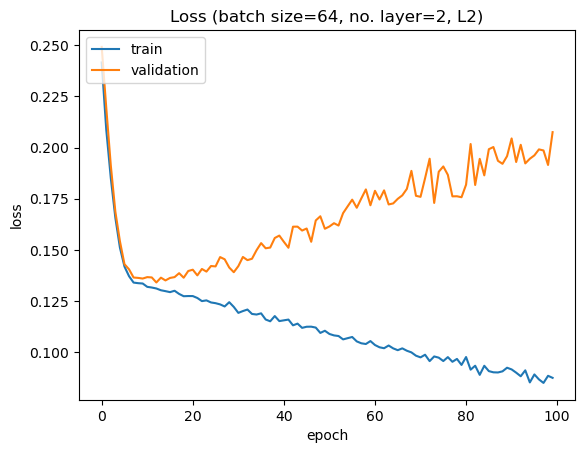

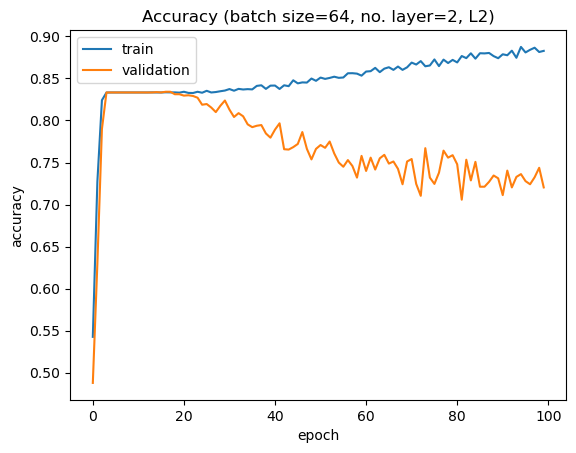

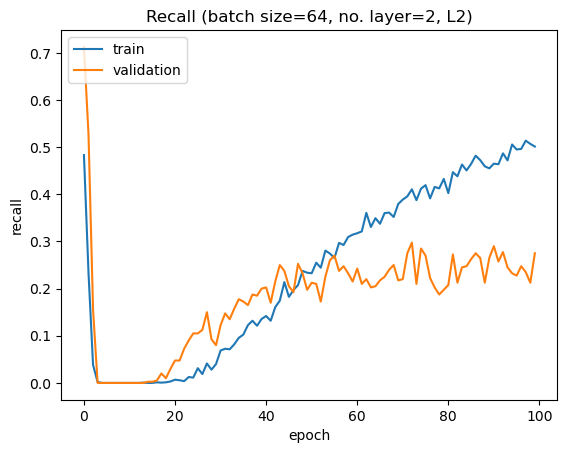

In [142]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [143]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.087
Training Accuracy: 0.883
Training Recall: 0.501


Validation Loss: 0.208
Validation Accuracy: 0.72
Validation Recall: 0.275


## densenet

In [144]:
# left_train = np.load('vgg_train_left.npy')
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

left_train = np.load('densenet_train_left.npy')
right_train = np.load('densenet_train_right.npy')
left_test = np.load('densenet_test_left.npy')
right_test = np.load('densenet_test_right.npy')

In [145]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [146]:
# input_shape = (512,)
# input_shape = (2048,)
input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\densenet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\densenet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [147]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2204 - accuracy: 0.6871 - recall_30: 0.1569 - val_loss: 0.1769 - val_accuracy: 0.7962 - val_recall_30: 0.0325
Epoch 2/100
600/600 - 1s - loss: 0.1532 - accuracy: 0.8292 - recall_30: 0.0075 - val_loss: 0.1453 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1400 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss: 0.1416 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1383 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss: 0.1416 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1380 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss: 0.1426 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1375 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss: 0.1436 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1365 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss:

Epoch 57/100
600/600 - 1s - loss: 0.0689 - accuracy: 0.9192 - recall_30: 0.6406 - val_loss: 0.3008 - val_accuracy: 0.6629 - val_recall_30: 0.1225
Epoch 58/100
600/600 - 1s - loss: 0.0675 - accuracy: 0.9209 - recall_30: 0.6431 - val_loss: 0.3175 - val_accuracy: 0.6488 - val_recall_30: 0.1350
Epoch 59/100
600/600 - 1s - loss: 0.0666 - accuracy: 0.9199 - recall_30: 0.6469 - val_loss: 0.3128 - val_accuracy: 0.6567 - val_recall_30: 0.1425
Epoch 60/100
600/600 - 1s - loss: 0.0659 - accuracy: 0.9232 - recall_30: 0.6575 - val_loss: 0.3049 - val_accuracy: 0.6671 - val_recall_30: 0.1375
Epoch 61/100
600/600 - 1s - loss: 0.0677 - accuracy: 0.9189 - recall_30: 0.6375 - val_loss: 0.3134 - val_accuracy: 0.6517 - val_recall_30: 0.1425
Epoch 62/100
600/600 - 1s - loss: 0.0649 - accuracy: 0.9250 - recall_30: 0.6581 - val_loss: 0.3195 - val_accuracy: 0.6467 - val_recall_30: 0.1525
Epoch 63/100
600/600 - 1s - loss: 0.0679 - accuracy: 0.9192 - recall_30: 0.6344 - val_loss: 0.3088 - val_accuracy: 0.6608 - 

#### Predict

In [148]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

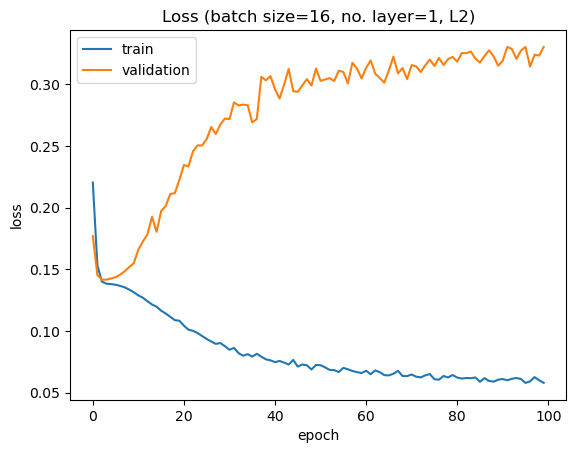

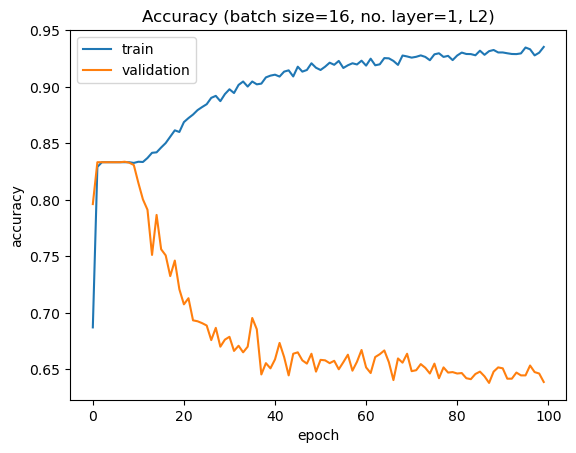

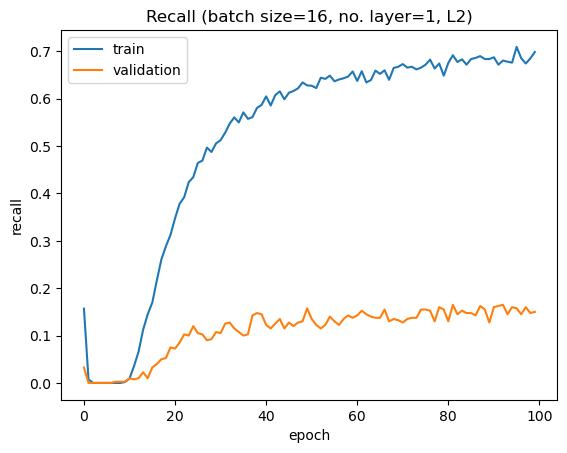

In [149]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [150]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.058
Training Accuracy: 0.935
Training Recall: 0.699


Validation Loss: 0.33
Validation Accuracy: 0.639
Validation Recall: 0.15


### batch size = 32, number of layer = 1

In [151]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.2118 - accuracy: 0.6866 - recall_31: 0.5531 - val_loss: 0.1578 - val_accuracy: 0.8188 - val_recall_31: 0.3150
Epoch 2/100
300/300 - 1s - loss: 0.1474 - accuracy: 0.8398 - recall_31: 0.5250 - val_loss: 0.1471 - val_accuracy: 0.8129 - val_recall_31: 0.3450
Epoch 3/100
300/300 - 1s - loss: 0.1076 - accuracy: 0.8771 - recall_31: 0.4963 - val_loss: 0.1270 - val_accuracy: 0.8313 - val_recall_31: 0.2400
Epoch 4/100
300/300 - 1s - loss: 0.0848 - accuracy: 0.9030 - recall_31: 0.5731 - val_loss: 0.1343 - val_accuracy: 0.8154 - val_recall_31: 0.2675
Epoch 5/100
300/300 - 1s - loss: 0.0663 - accuracy: 0.9267 - recall_31: 0.6806 - val_loss: 0.1376 - val_accuracy: 0.8125 - val_recall_31: 0.2550
Epoch 6/100
300/300 - 1s - loss: 0.0535 - accuracy: 0.9439 - recall_31: 0.7588 - val_loss: 0.1385 - val_accuracy: 0.8208 - val_recall_31: 0.2475
Epoch 7/100
300/300 - 1s - loss: 0.0426 - accuracy: 0.9552 - recall_31: 0.8112 - val_loss: 0.1454 - val_accuracy: 0.8138 - val_rec

Epoch 58/100
300/300 - 1s - loss: 0.0069 - accuracy: 0.9923 - recall_31: 0.9737 - val_loss: 0.1828 - val_accuracy: 0.7958 - val_recall_31: 0.3075
Epoch 59/100
300/300 - 1s - loss: 0.0111 - accuracy: 0.9860 - recall_31: 0.9463 - val_loss: 0.1803 - val_accuracy: 0.8000 - val_recall_31: 0.3150
Epoch 60/100
300/300 - 1s - loss: 0.0087 - accuracy: 0.9897 - recall_31: 0.9619 - val_loss: 0.1784 - val_accuracy: 0.8021 - val_recall_31: 0.3200
Epoch 61/100
300/300 - 1s - loss: 0.0083 - accuracy: 0.9899 - recall_31: 0.9688 - val_loss: 0.1798 - val_accuracy: 0.8000 - val_recall_31: 0.2850
Epoch 62/100
300/300 - 1s - loss: 0.0086 - accuracy: 0.9891 - recall_31: 0.9619 - val_loss: 0.1875 - val_accuracy: 0.7900 - val_recall_31: 0.3325
Epoch 63/100
300/300 - 1s - loss: 0.0083 - accuracy: 0.9906 - recall_31: 0.9638 - val_loss: 0.1852 - val_accuracy: 0.7912 - val_recall_31: 0.3125
Epoch 64/100
300/300 - 1s - loss: 0.0080 - accuracy: 0.9911 - recall_31: 0.9663 - val_loss: 0.1826 - val_accuracy: 0.7958 - 

#### Predict

In [152]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

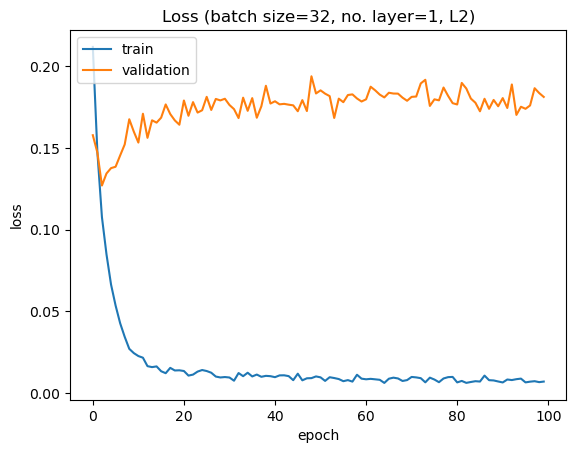

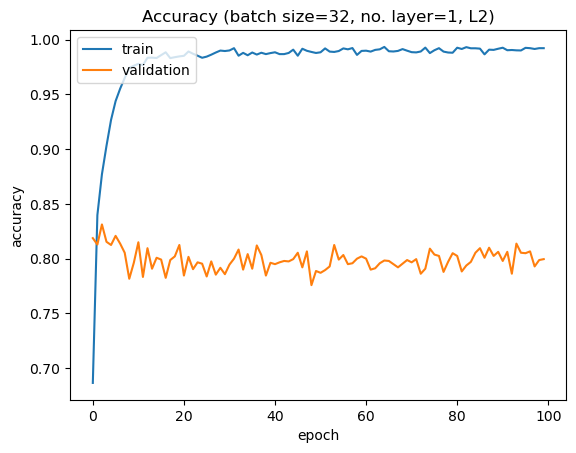

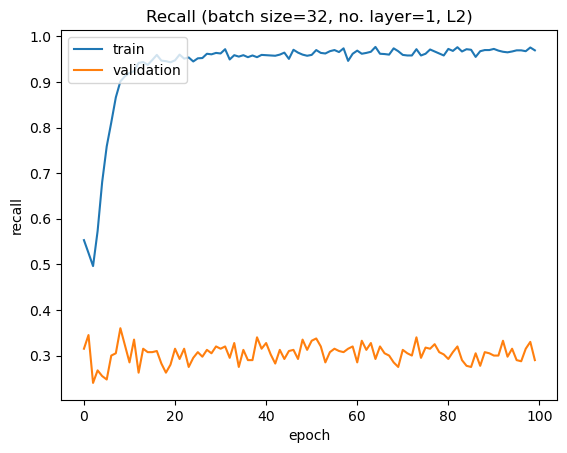

In [153]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [154]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.007
Training Accuracy: 0.992
Training Recall: 0.969


Validation Loss: 0.181
Validation Accuracy: 0.8
Validation Recall: 0.29


### batch size = 64, number of layer = 1

In [155]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.2251 - accuracy: 0.6419 - recall_32: 0.6375 - val_loss: 0.1484 - val_accuracy: 0.8354 - val_recall_32: 0.1800
Epoch 2/100
150/150 - 0s - loss: 0.1786 - accuracy: 0.7933 - recall_32: 0.6812 - val_loss: 0.1488 - val_accuracy: 0.8129 - val_recall_32: 0.3100
Epoch 3/100
150/150 - 0s - loss: 0.1384 - accuracy: 0.8617 - recall_32: 0.7075 - val_loss: 0.1448 - val_accuracy: 0.8075 - val_recall_32: 0.3325
Epoch 4/100
150/150 - 0s - loss: 0.1041 - accuracy: 0.9026 - recall_32: 0.7606 - val_loss: 0.1584 - val_accuracy: 0.7742 - val_recall_32: 0.4200
Epoch 5/100
150/150 - 0s - loss: 0.0787 - accuracy: 0.9331 - recall_32: 0.8144 - val_loss: 0.1442 - val_accuracy: 0.8021 - val_recall_32: 0.3225
Epoch 6/100
150/150 - 0s - loss: 0.0585 - accuracy: 0.9530 - recall_32: 0.8537 - val_loss: 0.1459 - val_accuracy: 0.7992 - val_recall_32: 0.3275
Epoch 7/100
150/150 - 0s - loss: 0.0438 - accuracy: 0.9668 - recall_32: 0.8975 - val_loss: 0.1609 - val_accuracy: 0.7771 - val_rec

Epoch 58/100
150/150 - 0s - loss: 0.0038 - accuracy: 0.9955 - recall_32: 0.9850 - val_loss: 0.1749 - val_accuracy: 0.8083 - val_recall_32: 0.2900
Epoch 59/100
150/150 - 0s - loss: 0.0042 - accuracy: 0.9952 - recall_32: 0.9875 - val_loss: 0.1809 - val_accuracy: 0.7921 - val_recall_32: 0.3125
Epoch 60/100
150/150 - 0s - loss: 0.0030 - accuracy: 0.9966 - recall_32: 0.9894 - val_loss: 0.2117 - val_accuracy: 0.7525 - val_recall_32: 0.3700
Epoch 61/100
150/150 - 0s - loss: 0.0024 - accuracy: 0.9976 - recall_32: 0.9925 - val_loss: 0.1825 - val_accuracy: 0.7933 - val_recall_32: 0.3075
Epoch 62/100
150/150 - 0s - loss: 0.0026 - accuracy: 0.9972 - recall_32: 0.9925 - val_loss: 0.1776 - val_accuracy: 0.7979 - val_recall_32: 0.2775
Epoch 63/100
150/150 - 0s - loss: 0.0021 - accuracy: 0.9980 - recall_32: 0.9931 - val_loss: 0.1792 - val_accuracy: 0.8012 - val_recall_32: 0.3125
Epoch 64/100
150/150 - 0s - loss: 0.0025 - accuracy: 0.9972 - recall_32: 0.9944 - val_loss: 0.1854 - val_accuracy: 0.7933 - 

#### Predict

In [156]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

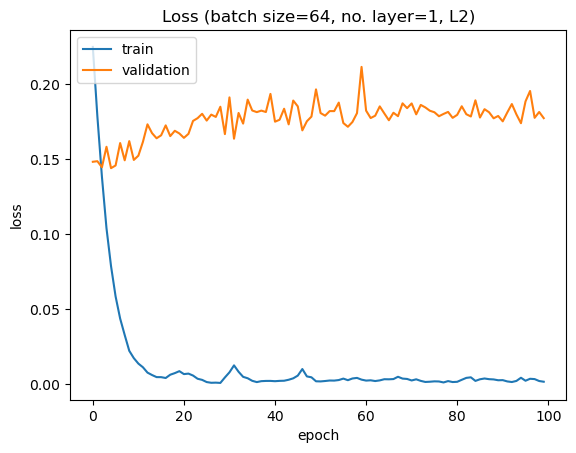

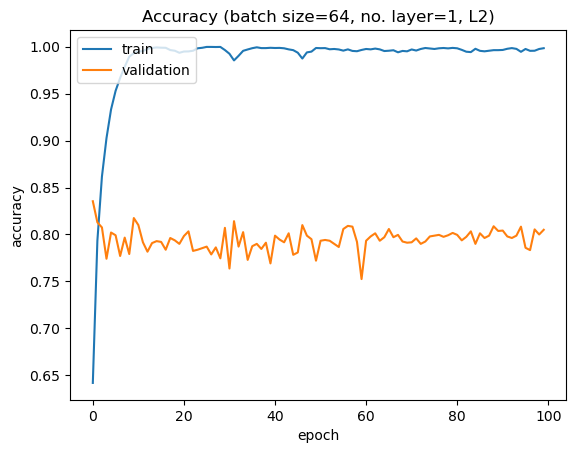

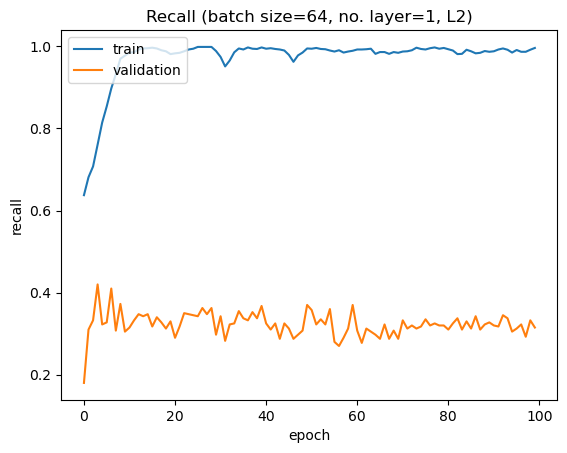

In [157]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [158]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.002
Training Accuracy: 0.998
Training Recall: 0.996


Validation Loss: 0.178
Validation Accuracy: 0.805
Validation Recall: 0.315


### batch size = 16, number of layer = 2

In [159]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\densenet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\densenet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [160]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2200 - accuracy: 0.6647 - recall_33: 0.2912 - val_loss: 0.3145 - val_accuracy: 0.3225 - val_recall_33: 0.8850
Epoch 2/100
600/600 - 1s - loss: 0.1463 - accuracy: 0.8319 - recall_33: 0.0000e+00 - val_loss: 0.1516 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1376 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1364 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1364 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1353 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1360 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1346 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1350 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1349 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1340 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_l

Epoch 57/100
600/600 - 1s - loss: 0.1183 - accuracy: 0.8335 - recall_33: 0.0975 - val_loss: 0.1363 - val_accuracy: 0.8258 - val_recall_33: 0.1725
Epoch 58/100
600/600 - 1s - loss: 0.1180 - accuracy: 0.8359 - recall_33: 0.0988 - val_loss: 0.1388 - val_accuracy: 0.8129 - val_recall_33: 0.1750
Epoch 59/100
600/600 - 1s - loss: 0.1185 - accuracy: 0.8374 - recall_33: 0.1031 - val_loss: 0.1372 - val_accuracy: 0.8175 - val_recall_33: 0.1625
Epoch 60/100
600/600 - 1s - loss: 0.1175 - accuracy: 0.8364 - recall_33: 0.1100 - val_loss: 0.1366 - val_accuracy: 0.8229 - val_recall_33: 0.1400
Epoch 61/100
600/600 - 1s - loss: 0.1161 - accuracy: 0.8360 - recall_33: 0.1213 - val_loss: 0.1380 - val_accuracy: 0.8158 - val_recall_33: 0.1875
Epoch 62/100
600/600 - 1s - loss: 0.1179 - accuracy: 0.8360 - recall_33: 0.1231 - val_loss: 0.1378 - val_accuracy: 0.8192 - val_recall_33: 0.1575
Epoch 63/100
600/600 - 1s - loss: 0.1187 - accuracy: 0.8353 - recall_33: 0.1100 - val_loss: 0.1376 - val_accuracy: 0.8200 - 

#### Predict

In [161]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

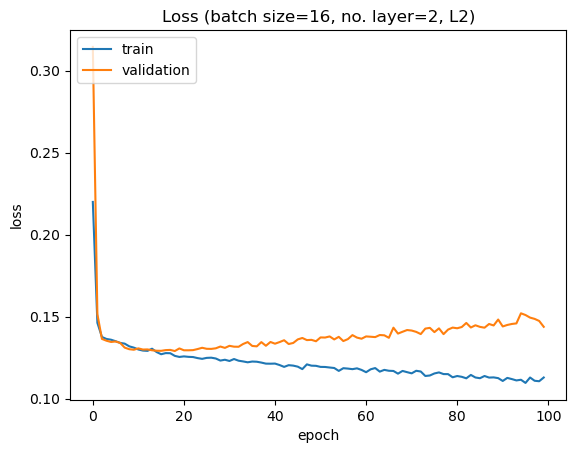

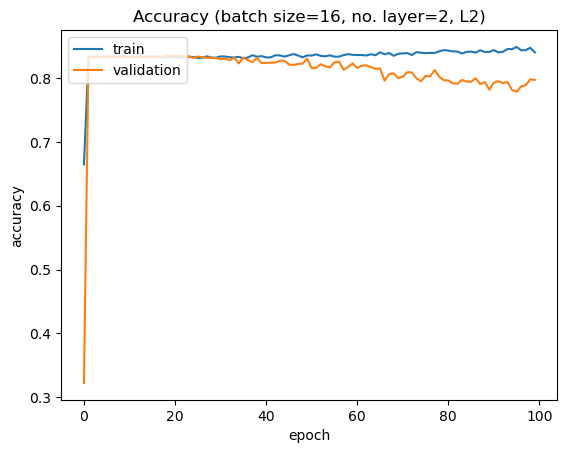

In [162]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [163]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.113
Training Accuracy: 0.84
Training Recall: 0.192


Validation Loss: 0.144
Validation Accuracy: 0.797
Validation Recall: 0.198


### batch size = 32, number of layer = 2

In [164]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.2284 - accuracy: 0.6183 - recall_34: 0.3812 - val_loss: 0.2791 - val_accuracy: 0.4350 - val_recall_34: 0.8075
Epoch 2/100
300/300 - 1s - loss: 0.1768 - accuracy: 0.8136 - recall_34: 0.0600 - val_loss: 0.1791 - val_accuracy: 0.8150 - val_recall_34: 0.1225
Epoch 3/100
300/300 - 1s - loss: 0.1495 - accuracy: 0.8332 - recall_34: 0.0000e+00 - val_loss: 0.1521 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 4/100
300/300 - 1s - loss: 0.1379 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1385 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 5/100
300/300 - 1s - loss: 0.1344 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1344 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 6/100
300/300 - 1s - loss: 0.1327 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1316 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 7/100
300/300 - 1s - loss: 0.1318 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1

Epoch 57/100
300/300 - 0s - loss: 0.1141 - accuracy: 0.8404 - recall_34: 0.1562 - val_loss: 0.1443 - val_accuracy: 0.7921 - val_recall_34: 0.2650
Epoch 58/100
300/300 - 1s - loss: 0.1150 - accuracy: 0.8397 - recall_34: 0.1488 - val_loss: 0.1459 - val_accuracy: 0.7879 - val_recall_34: 0.2875
Epoch 59/100
300/300 - 1s - loss: 0.1134 - accuracy: 0.8427 - recall_34: 0.1781 - val_loss: 0.1435 - val_accuracy: 0.7983 - val_recall_34: 0.2600
Epoch 60/100
300/300 - 1s - loss: 0.1131 - accuracy: 0.8422 - recall_34: 0.1713 - val_loss: 0.1511 - val_accuracy: 0.7817 - val_recall_34: 0.2975
Epoch 61/100
300/300 - 1s - loss: 0.1133 - accuracy: 0.8436 - recall_34: 0.1969 - val_loss: 0.1460 - val_accuracy: 0.7962 - val_recall_34: 0.2825
Epoch 62/100
300/300 - 1s - loss: 0.1121 - accuracy: 0.8420 - recall_34: 0.1988 - val_loss: 0.1462 - val_accuracy: 0.7933 - val_recall_34: 0.2875
Epoch 63/100
300/300 - 1s - loss: 0.1128 - accuracy: 0.8432 - recall_34: 0.2075 - val_loss: 0.1444 - val_accuracy: 0.7933 - 

#### Predict

In [165]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

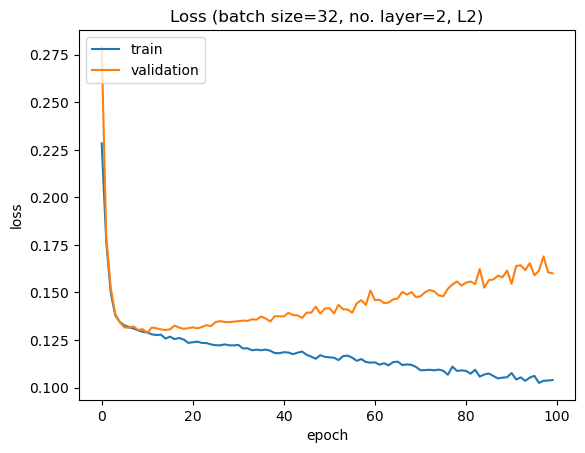

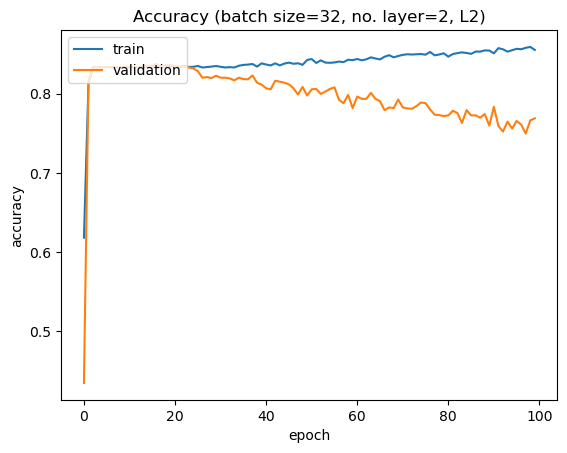

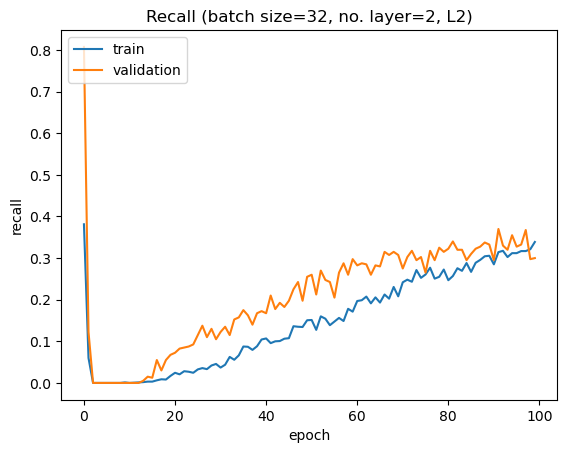

In [166]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [167]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.104
Training Accuracy: 0.855
Training Recall: 0.339


Validation Loss: 0.16
Validation Accuracy: 0.769
Validation Recall: 0.3


### batch size = 64, number of layer = 2

In [168]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.2386 - accuracy: 0.5978 - recall_35: 0.3894 - val_loss: 0.2884 - val_accuracy: 0.2700 - val_recall_35: 0.9475
Epoch 2/100
150/150 - 0s - loss: 0.2118 - accuracy: 0.7715 - recall_35: 0.1194 - val_loss: 0.2561 - val_accuracy: 0.4733 - val_recall_35: 0.7775
Epoch 3/100
150/150 - 0s - loss: 0.1863 - accuracy: 0.8234 - recall_35: 0.0325 - val_loss: 0.2141 - val_accuracy: 0.6317 - val_recall_35: 0.6000
Epoch 4/100
150/150 - 0s - loss: 0.1639 - accuracy: 0.8330 - recall_35: 0.0025 - val_loss: 0.1774 - val_accuracy: 0.7804 - val_recall_35: 0.2750
Epoch 5/100
150/150 - 0s - loss: 0.1481 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1563 - val_accuracy: 0.8338 - val_recall_35: 0.0025
Epoch 6/100
150/150 - 0s - loss: 0.1382 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1401 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00
Epoch 7/100
150/150 - 0s - loss: 0.1336 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1395 - val_accuracy: 

Epoch 57/100
150/150 - 0s - loss: 0.1058 - accuracy: 0.8558 - recall_35: 0.3000 - val_loss: 0.1490 - val_accuracy: 0.7850 - val_recall_35: 0.2975
Epoch 58/100
150/150 - 0s - loss: 0.1042 - accuracy: 0.8583 - recall_35: 0.3150 - val_loss: 0.1484 - val_accuracy: 0.7908 - val_recall_35: 0.3275
Epoch 59/100
150/150 - 0s - loss: 0.1027 - accuracy: 0.8608 - recall_35: 0.3288 - val_loss: 0.1512 - val_accuracy: 0.7846 - val_recall_35: 0.3275
Epoch 60/100
150/150 - 0s - loss: 0.1079 - accuracy: 0.8530 - recall_35: 0.2931 - val_loss: 0.1498 - val_accuracy: 0.7842 - val_recall_35: 0.3150
Epoch 61/100
150/150 - 0s - loss: 0.1046 - accuracy: 0.8597 - recall_35: 0.3256 - val_loss: 0.1489 - val_accuracy: 0.7912 - val_recall_35: 0.3275
Epoch 62/100
150/150 - 0s - loss: 0.1048 - accuracy: 0.8609 - recall_35: 0.3275 - val_loss: 0.1487 - val_accuracy: 0.7917 - val_recall_35: 0.3000
Epoch 63/100
150/150 - 0s - loss: 0.1046 - accuracy: 0.8567 - recall_35: 0.3206 - val_loss: 0.1516 - val_accuracy: 0.7796 - 

#### Predict

In [169]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

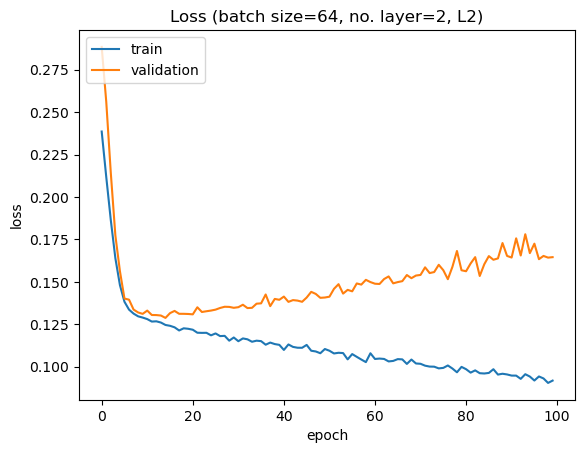

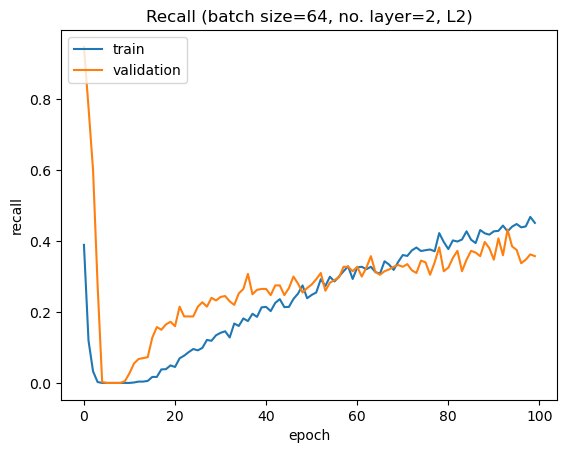

In [170]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [171]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.092
Training Accuracy: 0.878
Training Recall: 0.451


Validation Loss: 0.165
Validation Accuracy: 0.771
Validation Recall: 0.357
